In [1]:
%load_ext autoreload
%autoreload 2

import importlib

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import seirsplus

from seirsplus.viral_model import ViralExtSEIRNetworkModel, VL_PARAMS
from seirsplus.sim_loops_pooled_test import SimulationRunner

import warnings
warnings.filterwarnings('ignore')

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## correlated pooling

In [3]:
import copy

from seirsplus.networks import generate_demographic_contact_network, household_country_data

def generate_population(
    N, country, edge_weight, seed, distancing_scale
):

    random.seed(seed)
    np.random.seed(seed)

    demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                                N=N, demographic_data=household_country_data(country), 
                                                                distancing_scales=[distancing_scale], isolation_groups=[])
    # G = demographic_graphs['baseline']
    G = demographic_graphs[f'distancingScale{distancing_scale}']
    G_weighted = copy.deepcopy(G)
    for e in G.edges():
        if "weight" not in G[e[0]][e[1]]:
            G[e[0]][e[1]]["weight"] = edge_weight
    for e in G_weighted.edges():
        if "weight" not in G_weighted[e[0]][e[1]]:
            G_weighted[e[0]][e[1]]["weight"] = 10**10

    households_dict = {}
    for household in households:
        for node_id in household["indices"]:
            households_dict[node_id] = household["indices"]
    
    return G, G_weighted, households_dict

Generated overall age distribution:
0-9: 0.1144	(-0.0066 from target)
10-19: 0.1226	(-0.0084 from target)
20-29: 0.1378	(0.0008 from target)
30-39: 0.1366	(0.0036 from target)
40-49: 0.1230	(-0.0010 from target)
50-59: 0.1306	(-0.0004 from target)
60-69: 0.1140	(-0.0010 from target)
70-79: 0.0756	(0.0056 from target)
80+: 0.0454	(0.0074 from target)

Generated household size distribution:
1: 0.3022	(0.0185 from target)
2: 0.3378	(-0.0073 from target)
3: 0.1441	(-0.0066 from target)
4: 0.1239	(-0.0038 from target)
5: 0.0598	(0.0020 from target)
6: 0.0207	(-0.0019 from target)
7: 0.0116	(-0.0009 from target)
Num households: 2075
mean household size: 2.448393594

{'0-9': 572, '10-19': 613, '20-29': 689, '30-39': 683, '40-49': 615, '50-59': 653, '60-69': 570, '70-79': 378, '80+': 227}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Text(0.5, 1.0, 'Degree distribution')

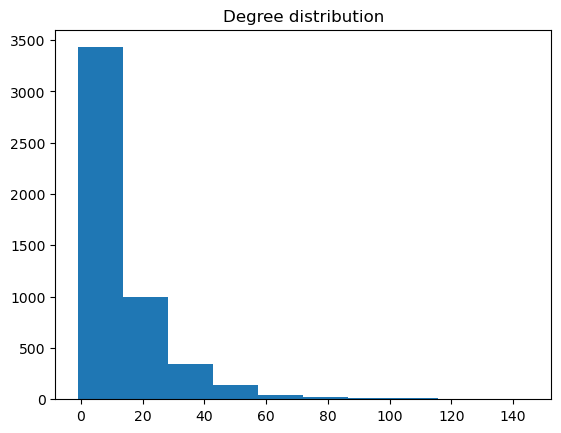

In [5]:
# run this if you want to see the degree distribution
G, G_weighted, households_dict = generate_population(5000, "US", 10, 0)
plt.hist([G.degree[i]-1 for i in range(5000)])
plt.title("Degree distribution") # centered at 10+1000*0.01=20, as expected

In [4]:
demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=1000, demographic_data=household_country_data("US"), 
                                                            distancing_scales=[100, 50, 1, 0.7], isolation_groups=[])

Generated overall age distribution:
0-9: 0.0920	(-0.0290 from target)
10-19: 0.1400	(0.0090 from target)
20-29: 0.1340	(-0.0030 from target)
30-39: 0.1350	(0.0020 from target)
40-49: 0.1120	(-0.0120 from target)
50-59: 0.1260	(-0.0050 from target)
60-69: 0.1340	(0.0190 from target)
70-79: 0.0730	(0.0030 from target)
80+: 0.0540	(0.0160 from target)

Generated household size distribution:
1: 0.2936	(0.0098 from target)
2: 0.3532	(0.0081 from target)
3: 0.1432	(-0.0075 from target)
4: 0.1337	(0.0060 from target)
5: 0.0453	(-0.0124 from target)
6: 0.0215	(-0.0011 from target)
7: 0.0095	(-0.0029 from target)
Num households: 419
mean household size: 2.448393594

{'0-9': 92, '10-19': 140, '20-29': 134, '30-39': 135, '40-49': 112, '50-59': 126, '60-69': 134, '70-79': 73, '80+': 54}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


In [15]:
demographic_graphs.keys()

dict_keys(['baseline', 'distancingScale0.7'])

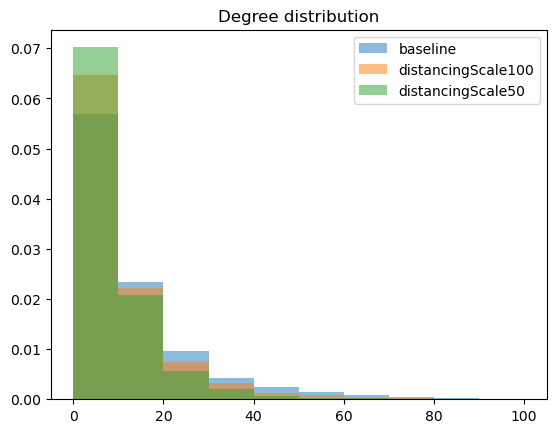

In [13]:
bins = np.linspace(0, 100, 11)

# for k in demographic_graphs.keys():
for k in ["baseline", "distancingScale100", "distancingScale50"]:
    plt.hist([demographic_graphs[k].degree[i]-1 for i in range(5000)], alpha=0.5, label=k, density=True, bins=bins)
plt.title("Degree distribution") # centered at 10+1000*0.01=20, as expected
plt.legend()

In [11]:
def run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T,
    pooling_strategy,
    NUM_SCREENING_GROUPS,
    POOL_SIZE,
    LoD,
    peak_VL,
    dilute,
    seed=0,
    COMMUNITY_SIZE=None,
):

    VL_params = copy.deepcopy(VL_PARAMS)
    for key in ["symptomatic", "asymptomatic"]:
        VL_params[key].update(
            {
                "peak_height": (peak_VL, peak_VL), 
                "start_peak": (3,5),
                "dt_peak": (1,1)
            }
        )

    
    test_model = ViralExtSEIRNetworkModel(
        G = G,
        G_weighted = G_weighted,
        households_dict=households_dict,
        VL_params=VL_params,
        beta = 0.1,
        beta_Q = 0,
        sigma = 0.2,
        lamda = 0.5,
        gamma  = 0.25,
        seed = seed,
        alpha = ALPHA,
        transition_mode="time_in_state",
        initE = N*INIT_PREV//2,
        initI_pre = N*INIT_PREV//2,
        # initI_pre = N*INIT_PREV,
        verbose=1,
        dilute=dilute,
    )
    sim = SimulationRunner(
        model=test_model,
        pooling_strategy=pooling_strategy,
        T = T,
        # num_groups = 10,
        num_groups = NUM_SCREENING_GROUPS,
        pool_size = POOL_SIZE,
        community_size=COMMUNITY_SIZE,
        LoD=LoD,
        seed = seed,
        save_results=False,
        verbose=2,
        max_dt=0.01,
    )
    sim.run_simulation()

    return sim

In [12]:
def run_sim_final(
    N,
    country,
    edge_weight,
    ALPHA,
    INIT_PREV,
    T,
    pooling_strategy,
    NUM_SCREENING_GROUPS,
    POOL_SIZE,
    LoD,
    peak_VL,
    distancing_scale,
    seed,
    dilute=True,
    COMMUNITY_SIZE = None
):

    G, G_weighted, households_dict = generate_population(N, country, edge_weight, seed, distancing_scale)

    sim = run_sim(
        G,
        G_weighted,
        households_dict,
        ALPHA,
        N,
        INIT_PREV,
        T=T,
        pooling_strategy=pooling_strategy,
        NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
        POOL_SIZE=POOL_SIZE,
        COMMUNITY_SIZE=COMMUNITY_SIZE,
        LoD=LoD,
        peak_VL=peak_VL,
        seed=seed,
        dilute=dilute
    )

    return sim

def plot_results(sim, pooling_strategy):

    fig, axs = plt.subplots(1, 5, figsize=(25, 3))

    # ps_label = "CP" if pooling_strategy == "correlated" else "NP"
    ps_label_dict = {
        "correlated": "CP",
        "naive": "NP",
        "correlated_weak": "CP_weak"
    }
    ps_label = ps_label_dict[pooling_strategy]

    axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
    axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
    axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
    axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
    axs[0].legend()
    axs[0].set_title(f"{ps_label} Infection counts")

    axs[2].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean pos", color="tab:blue")
    axs[2].plot([sim.overall_results[i]["mean_num_identifiable_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean id-able pos", color="tab:orange")
    # axs[2].plot([sim.overall_results[i]["median_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "--^", label="median positives", color="tab:blue")
    axs[2].plot([sim.overall_results[i]["median_num_identifiable_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "--^", label="med id-able pos", color="tab:orange")
    axs[2].set_title("Number of positives in positive pools")
    axs[2].legend()

    axs[1].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
    axs[1].set_title("Cumulative test consumption")

    axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
    axs[3].set_title(f"{ps_label} Daily test sensitivity")
    axs[3].set_ylim([0, 1])

    # axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
    # axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
    # axs[4].legend()
    # axs[4].set_title(f"{ps_label} # susceptible neighbors")

    axs[4].set_title(f"{ps_label} Secondary infections")

    bins = np.linspace(0, max(max(sim.model.sec_infs_household.values(), default=0), max(sim.model.sec_infs_non_household.values(), default=0)), 11)
    axs[4].hist(sim.model.sec_infs_household.values(), alpha=0.5, label="sec infs household", bins=bins)
    axs[4].hist(sim.model.sec_infs_non_household.values(), alpha=0.5, label="sec infs non-household", bins=bins)
    axs[4].legend()

    return fig

In [7]:
# nature parameters
WEIGHT = 10
LoD=1240
ALPHA=2
# also VL parameters

# epidemic control 
POOL_SIZE=10
COMMUNITY_SIZE=20
NUM_SCREENING_GROUPS = 5

PEAK_VL = 6.0

INIT_PREV=0.01
N=1000

SEED=0

T = 5

distancing_scale = 50 # try 1 or 0.7 next

DILUTE = TRUE

In [8]:
importlib.reload(seirsplus)

cp_sim = run_sim_final(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='correlated',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    distancing_scale=distancing_scale,
    seed=SEED,
    
)

np_sim = run_sim_final(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    distancing_scale=distancing_scale,
    seed=SEED,
)


Generated overall age distribution:
0-9: 0.1140	(-0.0070 from target)
10-19: 0.1310	(0.0000 from target)
20-29: 0.1410	(0.0040 from target)
30-39: 0.1440	(0.0110 from target)
40-49: 0.1170	(-0.0070 from target)
50-59: 0.1290	(-0.0020 from target)
60-69: 0.1020	(-0.0130 from target)
70-79: 0.0720	(0.0020 from target)
80+: 0.0500	(0.0120 from target)

Generated household size distribution:
1: 0.3259	(0.0422 from target)
2: 0.2988	(-0.0463 from target)
3: 0.1160	(-0.0346 from target)
4: 0.1481	(0.0205 from target)
5: 0.0691	(0.0114 from target)
6: 0.0346	(0.0119 from target)
7: 0.0074	(-0.0051 from target)
Num households: 405
mean household size: 2.448393594

{'0-9': 114, '10-19': 131, '20-29': 141, '30-39': 144, '40-49': 117, '50-59': 129, '60-69': 102, '70-79': 72, '80+': 50}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Running simulation with seed 0 for strategy correlated...
Running screening for group 0 on day 0...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 20.35it/s]


Viral loads in positive pools:  [[], [(926, -1.0, 3.0)], []]
Screening day:  0  self.model.t:  0.01
    Nodes with transition propensities:
        node300, in state [1], propensity [('StoE', 0.43478260869565216)]
infected: 300, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {298, 299, 301, 807}, non_household_neighbors: [496, 404, 245, 276, 344, 284]
Household member states: [array([1]), array([1]), array([1]), array([3])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]), array([1])]
Infected node 300 got contribution from infectious contacts {807: 1.0} and quarantined contacts {}
{'t': 0.12014594070067446, 'transitionNode': 300, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.43478260869565216, sum of all propensities: 7.904982195498805
    Nodes with transition propensities:
        node925, in state [1], propensity [('StoE', 0.39215686274509803)]
infected: 925, transmissionTerms_I: [10.], transmis

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 27.96it/s]


Viral loads in positive pools:  []
Screening day:  1  self.model.t:  1.0002741489836517
    Nodes with transition propensities:
        node202, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 202 is transitioning EtoIPRE at time 1.000276084523493 with timer_state: [1.00027608]; 1/sigma: [1.]; VL: 2.5808224469509553
{'t': 1.000276084523493, 'transitionNode': 202, 'transitionNodeVL': 3.0002694211113834, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 500003.2783794244
    Nodes with transition propensities:
        node314, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 314 is transitioning EtoIPRE at time 1.00027667842936 with timer_state: [1.00027668]; 1/sigma: [1.]; VL: 3.0001877075888648
{'t': 1.00027667842936, 'transitionNode': 314, 'transitionNodeVL': 3.0001881113805617, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 400004.7270123197
    Nodes with transition propensities:
        node857, in state [2], p

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 24.97it/s]


Viral loads in positive pools:  [[(807, -1.0, 4.44), (298, 1.1, 2.36), (300, 0.12, 3.46), (301, 0.73, 3.14)]]
Screening day:  2  self.model.t:  2.0058884383605875
    Nodes with transition propensities:
        node856, in state [1], propensity [('StoE', 0.45454545454545453)]
infected: 856, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {408, 409, 858, 857}, non_household_neighbors: [777, 780, 788, 846]
Household member states: [array([2]), array([1]), array([2]), array([3])]
Non-household member states: [array([1]), array([1]), array([1]), array([1])]
Infected node 856 got contribution from infectious contacts {857: 1.0} and quarantined contacts {}
{'t': 2.0311469003374434, 'transitionNode': 856, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.45454545454545453, sum of all propensities: 6.128665987808237
    Nodes with transition propensities:
        node753, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 753 is transitioning Et

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 28.32it/s]


Viral loads in positive pools:  [[(958, 0.86, 3.85), (959, -1.0, 5.33)], [(201, 1.27, 3.66), (202, 0.0, 4.93)], [(805, 2.66, 0.95)], [(936, 1.6, 3.31), (937, 2.84, 0.41)], [(839, 0.5, 4.37), (840, -1.0, 4.94)]]
Screening day:  3  self.model.t:  3.0078569016593106
    Nodes with transition propensities:
        node856, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 856 is transitioning EtoIPRE at time 3.037859515497306 with timer_state: [1.00671262]; 1/sigma: [1.]; VL: 2.8401300039656037
{'t': 3.037859515497306, 'transitionNode': 856, 'transitionNodeVL': 3.006430156568987, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100009.02149091524
    Nodes with transition propensities:
        node321, in state [1], propensity [('StoE', 0.0037735849056603774)]
infected: 321, transmissionTerms_I: [0.1], transmissionTerms_Q: [0], household_neighbors: {320, 123, 322, 18}, non_household_neighbors: [576, 292, 357, 325, 555, 314, 303, 335, 279, 666, 315, 343, 25

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 29.55it/s]


Viral loads in positive pools:  [[(753, 1.05, 4.22), (754, 0.0, 5.6)], [(312, 3.28, 2.12), (314, 0.0, 5.03)], [(254, -1.0, 5.74), (255, 2.64, 3.3)], [(198, 2.72, 3.18)]]
Screening day:  4  self.model.t:  4.004141076296703
    Nodes with transition propensities:
        node574, in state [1], propensity [('StoE', 1.2903225806451613)]
infected: 574, transmissionTerms_I: [20.], transmissionTerms_Q: [0], household_neighbors: {936, 937, 573}, non_household_neighbors: [350]
Household member states: [array([3]), array([3]), array([1])]
Non-household member states: [array([1])]
Infected node 574 got contribution from infectious contacts {936: 0.5, 937: 0.5} and quarantined contacts {}
{'t': 4.027849071302031, 'transitionNode': 574, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 1.2903225806451613, sum of all propensities: 9.629182919932147
    Nodes with transition propensities:
        node926, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 926 is transitioning IP

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 29.53it/s]


Viral loads in positive pools:  [[(904, 4.86, 0.41)], [(555, 3.26, 3.6), (556, 4.98, 0.03), (557, 4.21, 2.34), (558, 2.98, 3.75), (195, 1.89, 4.75)], [(738, 3.93, 3.04), (739, 1.57, 5.13), (740, 0.0, 5.56), (984, 1.47, 4.83)], [(545, 1.17, 5.09), (546, 1.35, 5.22), (547, 2.22, 4.13), (925, 0.26, 6.0), (926, -1.0, 5.7), (927, 0.34, 5.38)], [(856, 2.03, 4.88), (857, 0.0, 6.0), (858, 1.28, 4.75), (408, 1.26, 4.89), (409, 2.13, 4.6)]]
Screening day:  5  self.model.t:  5.001477080712105
    Nodes with transition propensities:
        node573, in state [1], propensity [('StoE', 1.3333333333333333)]
infected: 573, transmissionTerms_I: [20.], transmissionTerms_Q: [0], household_neighbors: {936, 937, 574}, non_household_neighbors: []
Household member states: [array([3]), array([3]), array([2])]
Non-household member states: []
Infected node 573 got contribution from infectious contacts {936: 0.5, 937: 0.5} and quarantined contacts {}
{'t': 5.024999456478544, 'transitionNode': 573, 'transitionNod

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Running simulation with seed 0 for strategy naive...
Running screening for group 0 on day 0...
Viral loads in positive pools:  [[], [(926, -1.0, 3.0)], []]
Screening day:  0  self.model.t:  0.01
    Nodes with transition propensities:
        node300, in state [1], propensity [('StoE', 0.43478260869565216)]
infected: 300, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {298, 299, 301, 807}, non_household_neighbors: [496, 404, 245, 276, 344, 284]
Household member states: [array([1]), array([1]), array([1]), array([3])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]), array([1])]
Infected node 300 got contribution from infectious contacts {807: 1.0} and quarantined contacts {}
{'t': 0.12014594070067446, 'transitionNode': 300, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.43478260869565216, sum of all propensities: 7.904982195498805
    Nodes with transition propensities:
        node925, in state [1],

In [22]:
importlib.reload(seirsplus)

cp_weak_sim = run_sim_final(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='correlated_weak',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    COMMUNITY_SIZE=COMMUNITY_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    distancing_scale=distancing_scale,
    seed=SEED,
)


Generated overall age distribution:
0-9: 0.1179	(-0.0031 from target)
10-19: 0.1252	(-0.0058 from target)
20-29: 0.1423	(0.0053 from target)
30-39: 0.1343	(0.0013 from target)
40-49: 0.1211	(-0.0029 from target)
50-59: 0.1276	(-0.0034 from target)
60-69: 0.1152	(0.0002 from target)
70-79: 0.0743	(0.0043 from target)
80+: 0.0421	(0.0041 from target)

Generated household size distribution:
1: 0.3001	(0.0164 from target)
2: 0.3337	(-0.0114 from target)
3: 0.1442	(-0.0065 from target)
4: 0.1242	(-0.0034 from target)
5: 0.0614	(0.0036 from target)
6: 0.0222	(-0.0005 from target)
7: 0.0141	(0.0017 from target)
Num households: 4105
mean household size: 2.448393594

{'0-9': 1179, '10-19': 1252, '20-29': 1423, '30-39': 1343, '40-49': 1211, '50-59': 1276, '60-69': 1152, '70-79': 743, '80+': 421}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


Running simulation with seed 0 for strategy correlated_weak...
    Nodes with transition propensities:
        node3611, in state [1], propensity [('StoE', 0.28169014084507044)]
infected: 3611, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {284, 3612, 1499, 1500, 3613, 3614}, non_household_neighbors: [2716, 2530, 2630, 3047, 2825, 4141, 7196, 5968, 5650, 2740, 2844]
Household member states: [array([1]), array([1]), array([1]), array([3]), array([1]), array([1])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1])]
Infected node 3611 got contribution from infectious contacts {1500: 1.0} and quarantined contacts {}
{'t': 0.007323374414130274, 'transitionNode': 3611, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.28169014084507044, sum of all propensities: 65.71313012345847
Running screening for group 0 on day 0...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Viral loads in positive pools:  [[(3431, -1.0, 3.0)], [(1550, -1.0, 3.0)], [(1279, -1.0, 3.0)], [(7737, 0.0, 0.02)], [(1500, -1.0, 3.01)], [], [(8435, -1.0, 3.01)], [(2053, -1.0, 3.01)], [(7096, 0.0, 0.02)], [(6433, 0.0, 0.02)], [(1349, -1.0, 3.01)], [(2429, -1.0, 3.01)], [(777, 0.0, 0.02)], [(7988, -1.0, 3.01)]]
Screening day:  0  self.model.t:  0.007323374414130274
    Nodes with transition propensities:
        node5568, in state [1], propensity [('StoE', 0.6896551724137931)]
infected: 5568, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {5569, 708}, non_household_neighbors: [4902, 5033, 3481, 2957, 3950, 6317, 3635, 7543, 5657]
Household member states: [array([1]), array([3])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1])]
Infected node 5568 got contribution from infectious contacts {708: 1.0} and quarantined contacts {}
{'t': 0.02591527580543467, 'transitionNode'

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Viral loads in positive pools:  [[(4647, 0.0, 3.0)], [(9973, -1.0, 3.92)], [(2737, -1.0, 3.88)], [(6730, -1.0, 3.66)], [(5454, -1.0, 3.76)], [(5837, 0.0, 3.0)], [(7259, -1.0, 3.73)], [(4184, -1.0, 3.69)], [(7498, 0.0, 3.0)], [(4106, 0.0, 3.0)], [(5255, 0.0, 3.0)], [(5920, 0.0, 3.0)], [(9074, 0.0, 3.0)], [(5972, -1.0, 3.98)], [(7898, 0.0, 3.0)], [(4022, 0.61, 1.15)], [(3076, 0.0, 3.0)], [(3386, 0.96, 0.11)], [(5219, -1.0, 3.62), (3077, 0.0, 3.0)], [(9938, -1.0, 3.68)], [(9939, 0.66, 1.02)], [(3202, 0.0, 3.0)], [(3440, -1.0, 3.61)], [(2617, 0.0, 3.0)], [(8233, 0.0, 3.0)]]
Screening day:  1  self.model.t:  1.0084053524600087
    Nodes with transition propensities:
        node5532, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 5532 is transitioning EtoIPRE at time 1.008405382552835 with timer_state: [1.00840538]; 1/sigma: [1.]; VL: 2.995216057380026
{'t': 1.008405382552835, 'transitionNode': 5532, 'transitionNodeVL': 3.0055606285426775, 'transitionType': 'EtoIPRE'}
propensity: 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Viral loads in positive pools:  [[(5532, 0.0, 3.66)], [(2701, 0.2, 3.54), (4072, -1.0, 4.39)], [(7310, 0.49, 3.38), (1098, 0.44, 3.4), (2344, -1.0, 4.71)], [(5830, 1.46, 1.59), (5829, 0.0, 3.88), (769, 1.06, 2.79)], [(6134, -1.0, 4.86)], [(5118, -1.0, 4.3)], [(8864, 0.36, 3.58)], [(7375, 1.35, 1.93)], [(1660, 0.71, 3.25), (4274, -1.0, 4.31), (1097, 0.86, 3.08), (432, 1.5, 1.46)], [(431, 0.18, 3.55), (4273, 1.3, 2.07)], [(4071, 1.74, 0.75)], [(9888, 1.28, 2.12)], [(3339, -1.0, 4.39), (3337, 1.63, 1.07)], [(3338, 1.71, 0.83), (201, 0.7, 3.19)], [(7899, 1.96, 0.1), (3836, -1.0, 4.21)], [(3837, 0.12, 3.57), (2885, -1.0, 4.4), (3840, 0.95, 3.02)], [(795, 1.42, 1.71)], [(2065, 0.38, 3.39)], [(6976, -1.0, 4.3)], [(9700, 1.44, 1.66), (6975, 0.39, 3.59)], [(1238, 1.4, 1.76)], [(1214, -1.0, 4.94)], [(4073, 1.27, 2.15)], [(4070, 1.92, 0.22)], [(1532, 0.0, 3.82)], [(887, -1.0, 4.33)], [(2105, 0.0, 3.99)], [(7043, 1.71, 0.83)], [(7042, 0.0, 3.72)], [(6963, 0.0, 3.82)], [(7376, 0.0, 3.81)], [(6423, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Viral loads in positive pools:  [[(92, 1.87, 3.09)], [(2851, 0.0, 4.2)], [(8310, 0.0, 4.6), (8311, 1.18, 3.62)], [(5898, 1.92, 3.07)], [(5428, 2.83, 0.5)], [(1912, 0.0, 4.39), (682, 2.3, 2.07)], [(8339, 0.0, 4.33)], [(8338, 1.1, 3.68)], [(8376, 1.22, 3.51)], [(4008, 2.67, 0.98)], [(1433, 1.43, 3.38), (3388, 0.45, 4.47), (210, 2.29, 2.13)], [(3385, 2.08, 2.75), (3387, -1.0, 5.75)], [(4056, 2.24, 2.26)], [(1250, 2.85, 0.45)], [(726, 2.97, 0.08), (1964, 0.0, 4.53)], [(5559, 2.76, 0.7), (5562, 1.03, 3.59), (5561, 1.41, 3.39), (5564, 2.11, 2.65)], [(5560, 0.0, 4.28), (705, 1.92, 3.06), (5563, 2.41, 1.76)], [(5899, 0.0, 4.98)], [(2022, 1.78, 3.19)], [(2334, -1.0, 5.34)], [(2333, 0.17, 4.47)], [(370, -1.0, 4.86), (4023, 0.24, 4.48)], [(2281, 1.04, 3.6)], [(1048, 0.0, 4.55), (2282, 2.32, 2.01)], [(849, 1.3, 3.52), (850, 1.47, 3.34)], [(851, 2.94, 0.16), (9324, 0.0, 4.35)], [(6356, 0.03, 4.2)], [(9418, -1.0, 5.13), (6357, 1.35, 3.57)], [(2369, 1.11, 3.55)], [(2370, 0.0, 4.26), (7415, 2.14, 2.56

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Viral loads in positive pools:  [[(1027, -1.0, 6.0)], [(8876, 0.55, 4.63), (8877, -1.0, 6.0)], [(9971, 0.0, 5.56), (9970, 1.33, 4.19)], [(7614, 1.15, 4.27)], [(3110, 0.04, 4.78)], [(3111, -1.0, 6.0)], [(2478, 0.64, 4.5)], [(9822, 3.25, 2.25)], [(4906, 2.2, 3.7), (8769, 0.0, 5.09), (8770, 1.61, 3.84)], [(1236, -1.0, 6.0)], [(2079, 0.0, 5.2), (6243, 3.77, 0.68)], [(6242, 3.88, 0.35), (6244, 1.97, 3.75), (6241, 2.57, 3.3)], [(708, -1.0, 5.56)], [(4098, 3.2, 2.39), (5568, 0.03, 4.82)], [(5569, 2.24, 3.46)], [(2048, 1.23, 4.47), (6003, 0.0, 5.55)], [(3081, -1.0, 5.51), (3080, 0.97, 4.91)], [(9748, 1.2, 4.23), (7093, 0.0, 5.27)], [(7094, 1.06, 4.56)], [(1613, 0.14, 4.99)], [(9543, 2.76, 3.17), (6637, 1.39, 4.52)], [(6638, 0.0, 5.77)], [(5061, 0.0, 5.38)], [(9968, 0.07, 4.76), (7607, 1.74, 4.24), (7606, 2.99, 3.0)], [(9969, -1.0, 6.0), (9967, 1.62, 4.36), (7608, 0.57, 5.29)], [(9169, 2.87, 3.09)], [(5784, -1.0, 6.0)], [(4626, 1.48, 4.23), (4629, 1.37, 4.11), (4628, 0.0, 5.6)], [(4627, 1.6, 3.

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Viral loads in positive pools:  [[(5774, 0.98, 4.87)], [(5773, 2.54, 3.9)], [(8435, -1.0, 6.0), (8434, 0.13, 5.89)], [(2789, 0.73, 5.03), (2785, 2.03, 4.56), (2784, 1.5, 5.17)], [(2788, 0.32, 6.0), (1279, -1.0, 6.0), (2787, 2.94, 3.91), (2786, 1.71, 4.39)], [(777, 0.0, 6.0)], [(2016, 2.22, 4.54)], [(2429, -1.0, 5.86), (7683, 0.53, 5.88)], [(7682, 1.45, 4.93), (2430, 0.31, 6.0)], [(1362, 2.44, 4.47)], [(1211, 2.43, 4.15)], [(3612, 1.51, 4.53), (1500, -1.0, 5.8), (284, 1.15, 4.97)], [(3614, 2.73, 3.85), (3611, 0.01, 5.55), (3613, 1.46, 5.45), (1499, 2.68, 3.85)], [(1026, 0.49, 5.46)], [(3851, 1.7, 4.76), (1550, -1.0, 6.0), (3850, 2.8, 4.09)], [(3848, 0.3, 5.91), (3849, 3.13, 3.61)], [(3433, 0.04, 5.98)], [(7987, 2.48, 4.02), (3432, 1.31, 4.75), (7988, -1.0, 6.0)], [(3069, 0.22, 5.48), (3070, 1.16, 4.81), (3071, 0.5, 5.54)], [(4645, 4.89, 0.32), (1750, 1.4, 4.68)], [(4646, 2.9, 4.01)], [(6035, 3.08, 3.61), (820, 3.0, 3.68), (2053, -1.0, 5.95), (6037, 0.96, 5.35)], [(6038, 0.78, 5.26), (60

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Viral loads in positive pools:  [[(4647, 0.0, 5.76)], [(8782, 5.15, 2.53)], [(3440, -1.0, 5.98)], [(5837, 0.0, 6.0)], [(4106, 0.0, 5.89)], [(3386, 0.96, 6.0), (6629, 5.81, 0.56)], [(5243, 4.2, 3.6)], [(1959, 4.58, 3.25)], [(4022, 0.61, 5.94), (4025, 4.98, 3.01)], [(4024, 2.69, 4.44), (4026, 3.45, 4.19)], [(5255, 0.0, 5.75), (5256, 2.13, 4.95), (3536, 2.88, 4.34)], [(3541, 5.84, 0.48)], [(4021, 5.83, 0.5)], [(7498, 0.0, 6.0)], [(7095, 3.7, 3.94)], [(3608, 2.04, 5.45)], [(2445, 4.25, 3.45)], [(4699, 4.41, 3.4)], [(3141, 4.21, 3.63), (146, 5.22, 2.33)], [(3139, 2.01, 4.9)], [(3574, 4.77, 3.16)], [(3482, 5.9, 0.3)], [(8120, 1.78, 5.93), (8118, 2.96, 4.23)], [(7840, 5.14, 2.58), (7059, 3.37, 4.08), (2736, 4.89, 3.08), (3201, 3.74, 4.24)], [(2737, -1.0, 5.43)], [(6378, 3.48, 4.09)], [(3451, 4.35, 3.48)], [(9938, -1.0, 5.75)], [(9939, 0.66, 5.79)], [(5972, -1.0, 5.35)], [(2506, 3.1, 4.57)], [(7688, 3.68, 3.9)], [(4007, 4.7, 3.25)], [(2466, 5.54, 1.38)], [(6869, 3.88, 4.09)], [(5454, -1.0, 5.5

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Viral loads in positive pools:  [[(3472, 6.22, 2.31), (1457, 3.71, 4.85)], [(886, 6.79, 0.62)], [(6538, 3.08, 5.08)], [(6537, 4.27, 4.24), (6536, 6.01, 2.94)], [(7900, 3.31, 4.81), (2885, -1.0, 5.44)], [(9694, 2.54, 5.67), (6963, 0.0, 5.42)], [(6962, 2.04, 5.76)], [(2517, 6.51, 1.43)], [(1531, 2.82, 5.4), (1532, 0.0, 5.43)], [(9700, 1.44, 5.75)], [(2541, 6.17, 2.48)], [(1214, -1.0, 5.13)], [(2701, 0.2, 5.88)], [(2702, 2.23, 5.56)], [(1238, 1.4, 6.0)], [(8234, 5.03, 3.75)], [(7687, 6.03, 2.88)], [(3140, 4.06, 4.51)], [(2934, 6.57, 1.28)], [(2105, 0.0, 5.38), (2414, 0.0, 5.67)], [(7634, 1.54, 6.0)], [(8625, 5.97, 3.02), (4609, 4.23, 4.72)], [(794, 3.76, 4.89), (5874, 1.48, 5.97), (5923, 2.7, 5.54), (795, 1.42, 5.85), (5875, 3.1, 5.08)], [(9213, 2.28, 5.77), (9214, -1.0, 5.06), (5876, 0.2, 5.56)], [(2113, 2.76, 5.4), (617, 1.2, 6.0), (2112, 0.0, 5.83), (616, 2.14, 5.81)], [(5063, 1.17, 6.0), (5064, 1.25, 6.0), (5062, 0.11, 5.58), (5065, -1.0, 5.41)], [(172, 5.68, 3.26)], [(2584, 5.47, 3.4

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Viral loads in positive pools:  [[(2750, 7.93, 0.21)], [(1271, 6.86, 3.1)], [(1935, 7.08, 2.75)], [(8801, 6.09, 3.76)], [(682, 2.3, 6.0), (1911, 3.99, 5.57)], [(5428, 2.83, 5.86), (1912, 0.0, 5.31)], [(847, 4.78, 4.91), (2629, 6.47, 3.44), (6128, 3.28, 5.9)], [(6127, 5.83, 3.71), (848, 5.44, 3.96)], [(8657, 6.64, 3.23)], [(3388, 0.45, 5.05), (1433, 1.43, 5.97), (210, 2.29, 6.0)], [(3385, 2.08, 6.0)], [(1249, 4.82, 4.43), (1414, 7.84, 0.47), (1250, 2.85, 6.0)], [(7729, 7.24, 2.27), (2511, 6.97, 3.02)], [(7728, 7.08, 2.75), (2510, 5.74, 3.91)], [(2334, -1.0, 4.79)], [(6289, 4.38, 4.9), (6288, 6.03, 3.89), (9399, 7.37, 1.89)], [(1242, 4.6, 4.91)], [(4055, 3.69, 5.1)], [(1594, 3.91, 5.11), (4056, 2.24, 6.0)], [(370, -1.0, 5.17), (4023, 0.24, 5.22)], [(4237, 7.72, 0.82), (8481, 6.58, 3.26)], [(5199, 3.44, 6.0), (8469, 5.25, 4.07), (5201, 6.31, 3.62)], [(4212, 7.92, 0.23), (637, 4.5, 4.56)], [(688, 7.91, 0.25)], [(4631, 6.98, 3.01), (2851, 0.0, 5.68)], [(92, 1.87, 6.0), (1295, 6.39, 3.54)], 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Viral loads in positive pools:  [[(7939, 1.18, 5.12)], [(2978, 2.56, 6.0), (2979, 1.82, 5.43)], [(7953, 3.29, 5.98)], [(3008, 1.63, 5.41), (7954, 2.14, 5.47)], [(2021, 1.72, 5.18), (5893, 1.4, 5.43)], [(8770, 1.61, 5.85)], [(3557, 8.69, 0.89)], [(3559, 8.8, 0.57), (3558, 7.35, 3.45)], [(176, 7.29, 3.49)], [(1402, 3.91, 5.69)], [(8584, 7.32, 3.5)], [(2478, 0.64, 5.4), (7716, 7.67, 3.24)], [(9417, 2.98, 6.0)], [(6353, 4.4, 6.0)], [(7473, 8.69, 0.88)], [(2075, 8.9, 0.26)], [(9647, 5.07, 5.08), (6860, 5.68, 4.41), (6861, 4.4, 5.82)], [(9648, 5.88, 4.44), (6862, 3.04, 6.0)], [(9822, 3.25, 5.74), (9823, 4.26, 5.38)], [(6807, 0.66, 4.87), (193, 5.95, 4.48), (6806, 1.09, 5.22)], [(6809, 1.82, 5.79), (6810, 0.81, 5.47), (194, 5.47, 5.24), (6804, 2.96, 6.0), (1417, 4.36, 5.5)], [(2434, 7.53, 3.28), (5, 4.82, 5.24), (1181, 5.95, 4.43)], [(1387, 7.49, 3.36)], [(2444, 4.28, 6.0), (7690, 2.54, 5.95)], [(8221, 2.67, 5.87)], [(8222, 3.98, 6.0), (3644, 5.8, 4.33)], [(1613, 0.14, 5.15)], [(1987, 3.85, 6

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Viral loads in positive pools:  [[(5606, 8.24, 3.46)], [(5605, 7.25, 4.74), (5604, 9.19, 2.4), (5603, 6.75, 4.69)], [(1049, 3.74, 5.64)], [(9457, 2.34, 5.51)], [(2016, 2.22, 5.09), (7738, 2.7, 5.79), (7987, 2.48, 5.64)], [(3815, 5.15, 5.71)], [(487, 9.13, 2.59)], [(4646, 2.9, 5.36), (3206, 6.98, 4.36), (1401, 7.35, 4.26), (4645, 4.89, 5.47), (1750, 1.4, 5.36), (3207, 5.88, 5.38)], [(3850, 2.8, 5.27), (4644, 5.14, 5.58)], [(5446, 6.9, 4.26)], [(1914, 7.94, 3.63)], [(3849, 3.13, 5.75)], [(4410, 1.68, 5.57)], [(1363, 1.91, 4.94), (3075, 1.52, 5.3)], [(1362, 2.44, 5.25)], [(2637, 7.31, 4.45), (7799, 5.93, 5.7)], [(1509, 7.37, 4.06), (296, 9.87, 0.36)], [(1305, 9.44, 1.67)], [(5773, 2.54, 5.77)], [(3138, 4.64, 5.63), (1372, 8.99, 3.0)], [(8895, 6.16, 4.76)], [(5191, 5.13, 5.5)], [(1538, 6.56, 4.52), (3770, 8.71, 3.24), (317, 9.54, 1.35), (5774, 0.98, 5.07)], [(1348, 2.94, 5.97)], [(2283, 2.4, 5.12), (7097, 1.74, 4.92), (3816, 6.5, 4.91)], [(1548, 7.77, 3.8), (2284, 3.31, 5.81)], [(1715, 6.3

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Viral loads in positive pools:  [[(3541, 5.84, 5.77)], [(4408, 7.87, 4.45)], [(5922, 4.94, 6.0)], [(3714, 9.47, 3.52)], [(3678, 9.83, 3.13)], [(3375, 10.5, 1.48)], [(3592, 6.46, 5.42)], [(7802, 7.02, 5.78), (7688, 3.68, 5.7)], [(3359, 8.03, 4.63)], [(7059, 3.37, 5.55), (8326, 10.43, 1.67)], [(6869, 3.88, 5.28)], [(7630, 9.34, 3.42)], [(4806, 5.71, 6.0), (3451, 4.35, 5.81)], [(4007, 4.7, 5.79), (2604, 6.42, 5.55)], [(2587, 6.68, 5.1), (2589, 8.46, 4.08), (3574, 4.77, 6.0), (2588, 7.99, 4.38)], [(6542, 10.01, 2.93)], [(3621, 6.76, 5.15)], [(8085, 6.46, 5.23), (8084, 5.44, 5.92)], [(4086, 5.06, 6.0)], [(1431, 10.56, 1.28)], [(2890, 6.89, 5.17)], [(4133, 5.76, 5.97)], [(2736, 4.89, 5.92)], [(7840, 5.14, 6.0)], [(2558, 8.55, 4.3), (4097, 10.37, 1.87)], [(3752, 10.35, 1.92)], [(3259, 8.16, 4.23)], [(3218, 7.52, 4.52)], [(3685, 5.3, 6.0)], [(2445, 4.25, 6.0), (6506, 7.48, 5.18)], [(7992, 1.98, 5.04)], [(6629, 5.81, 6.0)], [(5703, 6.45, 6.0)], [(5743, 7.61, 4.58)], [(4919, 9.58, 3.29)], [(2830

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Viral loads in positive pools:  [[(4221, 11.86, 0.42)], [(9096, 9.4, 4.1)], [(5641, 8.15, 5.72)], [(4085, 11.5, 1.51)], [(3866, 11.58, 1.26)], [(887, -1.0, 3.23)], [(172, 5.68, 5.69), (6977, 3.17, 4.74), (2344, -1.0, 3.34), (3827, 5.05, 5.82)], [(2663, 11.6, 1.22), (3713, 9.96, 3.99), (3712, 8.83, 4.94), (3711, 7.02, 6.0)], [(1517, 10.02, 3.83)], [(8234, 5.03, 5.6), (3140, 4.06, 5.3)], [(886, 6.79, 5.8)], [(2104, 9.08, 4.44)], [(3472, 6.22, 5.88)], [(1458, 7.73, 5.07), (1457, 3.71, 5.0)], [(6538, 3.08, 4.97)], [(3171, 10.54, 3.37)], [(8086, 6.85, 5.9)], [(3260, 9.32, 4.21)], [(2886, 4.25, 5.37)], [(2934, 6.57, 5.74), (2935, 3.72, 5.28)], [(7811, 5.9, 5.61)], [(2654, 7.0, 6.0), (2653, 6.48, 6.0), (2655, 4.17, 5.13)], [(7687, 6.03, 5.99)], [(4143, 10.03, 3.86)], [(1214, -1.0, 3.62)], [(2541, 6.17, 5.79)], [(8625, 5.97, 5.61)], [(4609, 4.23, 5.18)], [(2585, 4.82, 5.75)], [(2584, 5.47, 5.46), (43, 7.55, 5.62)], [(2465, 10.65, 3.27), (6401, 10.78, 3.2), (2464, 6.78, 5.66), (9446, 9.03, 4.33

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Viral loads in positive pools:  [[(4237, 7.72, 5.95)], [(8481, 6.58, 6.0)], [(7001, 12.23, 2.28)], [(8469, 5.25, 5.68), (4212, 7.92, 6.0), (56, 11.76, 3.17)], [(5200, 5.47, 5.53), (637, 4.5, 5.4)], [(5201, 6.31, 5.44)], [(1935, 7.08, 6.0)], [(2334, -1.0, 3.0)], [(2469, 12.09, 2.69), (2471, 10.21, 4.28), (2470, 12.62, 1.09), (7707, 11.94, 3.04)], [(4631, 6.98, 5.91), (521, 8.05, 5.56)], [(4630, 8.31, 5.45)], [(1934, 9.04, 5.14)], [(1310, 12.45, 1.6)], [(4669, 8.3, 6.0)], [(8657, 6.64, 6.0), (8656, 8.59, 5.1), (4668, 8.37, 6.0)], [(7728, 7.08, 5.88), (2511, 6.97, 5.64), (2510, 5.74, 5.64)], [(7729, 7.24, 5.96)], [(4381, 10.47, 4.0), (8524, 9.25, 4.99)], [(4695, 11.42, 3.47), (4693, 10.18, 4.35), (4691, 12.04, 2.85), (8664, 12.37, 1.84)], [(191, 9.06, 5.53)], [(2750, 7.93, 5.55), (1272, 8.66, 5.32), (77, 8.02, 6.0)], [(205, 12.83, 0.47), (1271, 6.86, 6.0), (2749, 6.15, 5.39)], [(3755, 5.43, 5.78), (3754, 8.08, 5.8), (3757, 9.71, 4.42), (3756, 7.51, 6.0)], [(8265, 7.51, 5.92), (8264, 7.44,

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Viral loads in positive pools:  [[(9267, 1.12, 3.41)], [(50, 13.76, 0.69)], [(3191, 13.93, 0.2), (3194, 13.36, 1.9)], [(170, 11.64, 3.91), (3193, 10.3, 4.66)], [(7939, 1.18, 3.46)], [(6192, 12.42, 3.46), (2075, 8.9, 6.0)], [(2076, 10.66, 4.42)], [(1832, 13.22, 2.33)], [(1235, 2.27, 3.49)], [(6533, 13.68, 0.95)], [(4995, 12.23, 3.53)], [(1613, 0.14, 3.48)], [(176, 7.29, 5.86)], [(3644, 5.8, 5.58)], [(3270, 13.98, 0.03)], [(1181, 5.95, 5.43)], [(2434, 7.53, 6.0)], [(5568, 0.03, 3.7)], [(7497, 6.51, 5.56), (7607, 1.74, 3.64), (6637, 1.39, 3.64)], [(1604, 5.24, 4.98)], [(8584, 7.32, 5.8), (4508, 10.19, 5.27)], [(1188, 11.08, 4.44), (11, 12.4, 3.43)], [(3273, 11.9, 3.9)], [(8037, 11.05, 4.32), (160, 12.13, 3.6), (1387, 7.49, 5.88)], [(129, 13.87, 0.37)], [(130, 12.75, 3.16)], [(8810, 10.36, 5.17)], [(9429, 10.39, 5.02), (6365, 8.61, 5.66), (9428, 11.3, 4.61)], [(1702, 12.89, 3.07), (9556, 11.65, 4.16)], [(5, 4.82, 4.75)], [(7724, 10.3, 5.2)], [(5061, 0.0, 3.35)], [(3041, 7.35, 5.97), (1353,

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Viral loads in positive pools:  [[(1345, 14.86, 0.43)], [(5608, 12.41, 4.29)], [(3024, 13.58, 3.31), (3023, 14.62, 1.16)], [(8926, 8.4, 5.63)], [(8927, 7.39, 5.8)], [(1362, 2.44, 3.66)], [(6736, 11.21, 4.86), (6739, 12.39, 4.1)], [(6737, 12.67, 3.84), (971, 12.27, 4.06), (6738, 12.95, 4.05)], [(5604, 9.19, 5.9), (5603, 6.75, 5.3), (5605, 7.25, 5.1), (5606, 8.24, 6.0)], [(5757, 7.81, 5.28)], [(3661, 8.84, 6.0), (8895, 6.16, 5.16)], [(1975, 12.85, 3.78), (1976, 14.7, 0.92)], [(1715, 6.32, 5.15), (487, 9.13, 5.74), (488, 9.41, 5.93)], [(1305, 9.44, 5.95), (1306, 11.73, 4.41)], [(8196, 11.67, 4.54)], [(3552, 13.28, 3.58)], [(1527, 7.02, 5.55)], [(1526, 9.62, 5.82)], [(1548, 7.77, 5.79), (1475, 10.38, 5.48), (1474, 9.17, 6.0)], [(3554, 10.62, 5.36)], [(4323, 12.11, 4.36), (8498, 13.75, 3.15), (8499, 10.98, 5.93)], [(2394, 13.23, 3.71), (7551, 14.3, 2.09), (7550, 12.12, 4.53)], [(9086, 13.43, 3.39)], [(5446, 6.9, 5.62)], [(1914, 7.94, 5.97)], [(296, 9.87, 6.0), (1509, 7.37, 5.66)], [(316, 11

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Viral loads in positive pools:  [[(6798, 12.0, 5.1)], [(3752, 10.35, 5.88)], [(5413, 14.44, 3.39), (8386, 8.43, 5.53), (5382, 10.14, 6.0)], [(3714, 9.47, 5.52)], [(4326, 13.57, 4.38)], [(3375, 10.5, 6.0)], [(6081, 12.05, 4.81), (6373, 14.26, 3.44)], [(6502, 7.81, 5.58), (4277, 9.2, 5.78), (3905, 8.7, 5.47)], [(5139, 12.92, 5.02), (6892, 11.07, 6.0), (7422, 12.52, 4.81)], [(3066, 12.27, 4.74)], [(3706, 15.67, 0.96), (7630, 9.34, 5.99)], [(80, 12.51, 4.75)], [(2783, 13.76, 3.75)], [(4731, 11.19, 6.0)], [(3678, 9.83, 5.81)], [(2529, 13.49, 4.0)], [(3769, 12.1, 5.45)], [(1431, 10.56, 6.0), (1430, 15.43, 1.69)], [(2597, 12.02, 4.97)], [(1379, 15.64, 1.07), (1381, 12.82, 4.31), (3151, 15.66, 1.0)], [(1382, 15.45, 1.62), (7992, 1.98, 3.39), (8028, 11.1, 5.44), (1380, 14.51, 3.3)], [(3359, 8.03, 5.28)], [(4732, 15.86, 0.4), (4733, 14.76, 3.16)], [(4734, 15.79, 0.63)], [(9990, 14.69, 3.2)], [(2479, 14.95, 3.04)], [(6896, 13.97, 3.63)], [(2890, 6.89, 5.09)], [(7770, 8.8, 5.5)], [(7713, 10.78, 5.

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Viral loads in positive pools:  [[(3532, 13.27, 5.18)], [(3459, 11.5, 6.0)], [(1452, 14.28, 4.53)], [(9446, 9.03, 5.47), (6401, 10.78, 5.69)], [(887, -1.0, 3.0)], [(2344, -1.0, 3.0), (9850, 4.56, 3.09), (2465, 10.65, 5.86), (6538, 3.08, 3.1)], [(1214, -1.0, 3.0)], [(3171, 10.54, 5.76)], [(1393, 13.16, 5.26)], [(3729, 16.09, 2.68)], [(2877, 13.25, 4.77), (7894, 8.93, 5.32)], [(1370, 10.56, 6.0)], [(3865, 14.38, 4.05)], [(3868, 14.07, 4.26), (3866, 11.58, 5.94), (3867, 12.8, 4.93), (3869, 14.13, 4.43), (3870, 13.24, 5.28)], [(3260, 9.32, 5.37)], [(4822, 12.73, 5.16), (1409, 10.62, 5.7), (1410, 8.72, 4.93)], [(2664, 10.57, 5.63)], [(2662, 13.39, 5.56), (1251, 10.86, 5.64), (2663, 11.6, 6.0)], [(1458, 7.73, 4.93), (1457, 3.71, 3.09)], [(1358, 12.77, 5.79), (3059, 16.76, 0.67)], [(4143, 10.03, 5.41), (401, 12.27, 5.28)], [(4222, 14.11, 4.18), (2104, 9.08, 5.25), (4221, 11.86, 5.63)], [(8472, 14.31, 4.03), (1304, 13.23, 5.23), (8473, 13.75, 4.7), (4220, 13.01, 5.18), (1303, 14.78, 3.89)], [(

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Viral loads in positive pools:  [[(8524, 9.25, 4.95)], [(1934, 9.04, 5.15)], [(3381, 9.05, 5.02), (7496, 4.77, 3.0)], [(2467, 13.87, 5.77), (7707, 11.94, 5.84), (2470, 12.62, 6.0), (2469, 12.09, 5.8), (2471, 10.21, 5.52)], [(2468, 16.8, 3.14)], [(420, 10.13, 5.28)], [(3733, 13.81, 6.0), (305, 11.73, 5.68)], [(3453, 17.71, 0.82)], [(3387, -1.0, 3.0)], [(56, 11.76, 5.96), (1242, 4.6, 3.4)], [(2051, 11.75, 6.0), (816, 12.79, 6.0)], [(605, 15.38, 4.21)], [(7002, 15.56, 4.19), (9716, 15.83, 3.88), (9717, 15.81, 4.09), (7001, 12.23, 6.0)], [(7003, 15.33, 4.32), (9715, 16.58, 3.28)], [(1267, 11.76, 6.0)], [(1265, 13.46, 5.18)], [(1310, 12.45, 6.0), (2903, 14.11, 5.6)], [(4695, 11.42, 5.71), (4694, 13.42, 5.61), (8663, 15.83, 4.04)], [(4693, 10.18, 5.27), (4691, 12.04, 5.68), (4692, 13.52, 5.96), (8664, 12.37, 5.88)], [(8567, 14.8, 5.15), (4472, 13.49, 5.61)], [(7904, 9.48, 5.42)], [(2901, 5.79, 3.23)], [(1544, 15.51, 4.33), (3792, 17.34, 1.92), (2918, 17.14, 2.55), (7912, 14.22, 4.87)], [(170

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Viral loads in positive pools:  [[(882, 18.28, 2.14), (6346, 16.96, 3.96)], [(7952, 0.35, 3.0)], [(1702, 12.89, 6.0), (1701, 14.73, 5.35)], [(2076, 10.66, 5.56), (472, 18.54, 1.38)], [(9496, 15.54, 4.51), (134, 18.28, 2.14)], [(6533, 13.68, 6.0)], [(1416, 15.68, 4.56)], [(5061, 0.0, 3.0)], [(208, 17.73, 3.17)], [(3374, 15.71, 5.13), (3372, 17.18, 3.63)], [(6637, 1.39, 3.0), (6638, 0.0, 3.0)], [(160, 12.13, 5.8), (8037, 11.05, 5.49)], [(9556, 11.65, 5.43), (1604, 5.24, 3.32), (9971, 0.0, 3.0), (5536, 12.8, 6.0)], [(1027, -1.0, 3.0), (5, 4.82, 3.0)], [(3194, 13.36, 6.0)], [(3191, 13.93, 5.47), (3193, 10.3, 5.31)], [(1611, 16.49, 4.2)], [(1612, 15.29, 4.75)], [(1157, 16.75, 4.01), (1158, 17.68, 3.28)], [(7581, 16.9, 3.84), (2404, 15.59, 5.04), (2403, 18.7, 0.89)], [(8197, 15.27, 5.44), (3571, 18.35, 1.94)], [(3573, 17.09, 3.64)], [(2478, 0.64, 3.0), (1469, 17.22, 3.51)], [(1993, 16.63, 3.88)], [(1235, 2.27, 3.0)], [(1236, -1.0, 3.0)], [(178, 17.98, 3.02), (3248, 16.74, 3.96), (2630, 18.01

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Viral loads in positive pools:  [[(7854, 17.83, 3.78), (2762, 18.37, 3.55)], [(7855, 16.27, 4.73)], [(3553, 13.22, 5.97), (8196, 11.67, 5.33)], [(3552, 13.28, 5.62)], [(7809, 5.7, 3.0), (3554, 10.62, 5.02), (1026, 0.49, 3.0)], [(1306, 11.73, 5.57), (5757, 7.81, 3.61)], [(5774, 0.98, 3.0)], [(5116, 10.99, 5.0)], [(6842, 19.24, 2.26)], [(3106, 14.47, 5.75), (3108, 15.06, 6.0), (3107, 14.6, 5.9)], [(3105, 15.99, 5.38), (8007, 12.93, 5.81)], [(1464, 18.77, 3.18)], [(3611, 0.01, 3.0)], [(1540, 16.65, 4.89)], [(5608, 12.41, 5.27), (9086, 13.43, 5.96)], [(2053, -1.0, 3.0), (6433, 0.0, 3.0)], [(6434, 1.67, 3.0), (6037, 0.96, 3.0)], [(4323, 12.11, 5.31)], [(7682, 1.45, 3.0)], [(1261, 19.24, 2.28)], [(2692, 16.33, 5.17)], [(3851, 1.7, 3.0)], [(3848, 0.3, 3.0), (284, 1.15, 3.0), (7098, 2.18, 3.0)], [(2395, 15.37, 5.84), (2394, 13.23, 5.5), (7552, 15.97, 5.67)], [(7550, 12.12, 5.3), (7551, 14.3, 5.99)], [(6739, 12.39, 5.51), (6737, 12.67, 5.81), (6738, 12.95, 5.24)], [(971, 12.27, 5.75), (6736, 11

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Viral loads in positive pools:  [[(5280, 19.56, 3.28), (5284, 18.67, 4.01), (8934, 17.82, 4.42), (5282, 16.77, 4.94)], [(5281, 19.45, 3.5)], [(2890, 6.89, 3.47), (3195, 20.26, 2.23)], [(6896, 13.97, 5.94)], [(3029, 19.87, 3.08), (2867, 18.96, 3.75)], [(6869, 3.88, 3.0)], [(5019, 18.05, 4.31)], [(1379, 15.64, 6.0)], [(1382, 15.45, 5.88), (1381, 12.82, 5.61), (3151, 15.66, 6.0), (1380, 14.51, 6.0)], [(3602, 18.09, 4.28), (2458, 19.63, 3.22), (1196, 17.08, 5.18), (3603, 19.38, 3.61), (8207, 20.9, 0.31), (1195, 16.07, 5.84)], [(3600, 19.83, 3.14), (2459, 18.23, 4.58)], [(3717, 14.35, 6.0)], [(3077, 0.0, 3.0)], [(3684, 2.37, 3.0)], [(6373, 14.26, 6.0), (8233, 0.0, 3.0)], [(3129, 3.47, 3.0), (4125, 1.67, 3.0)], [(44, 11.81, 4.88)], [(3359, 8.03, 3.73)], [(2597, 12.02, 5.06)], [(5256, 2.13, 3.0)], [(5000, 17.04, 4.87), (2904, 18.26, 4.52)], [(4916, 17.23, 5.09), (2454, 17.24, 5.2)], [(6305, 19.37, 3.55)], [(4734, 15.79, 6.0), (8677, 16.08, 5.59), (8676, 16.9, 4.92)], [(4733, 14.76, 6.0), (473

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Viral loads in positive pools:  [[(3865, 14.38, 5.64)], [(4273, 1.3, 3.0), (4609, 4.23, 3.0)], [(1452, 14.28, 5.04), (3457, 14.86, 5.38)], [(3458, 12.86, 4.8)], [(3868, 14.07, 5.51)], [(1494, 13.92, 5.52)], [(3532, 13.27, 5.1)], [(3148, 16.83, 5.66), (3147, 15.83, 5.8)], [(5410, 21.55, 1.33), (1906, 20.23, 3.46)], [(1904, 21.44, 1.68)], [(3185, 19.08, 4.29)], [(3184, 19.45, 4.37), (3183, 18.01, 5.31), (3182, 19.52, 3.99)], [(1878, 20.24, 3.7), (8939, 21.5, 1.49)], [(4268, 14.6, 5.57), (4269, 14.97, 5.51)], [(7708, 20.84, 3.11)], [(7041, 2.74, 3.0), (7709, 20.98, 3.01)], [(5962, 21.8, 0.6)], [(5599, 21.73, 0.81)], [(9850, 4.56, 3.0), (1393, 13.16, 5.06)], [(7922, 21.78, 0.64)], [(4082, 15.64, 5.77), (3128, 8.71, 3.6)], [(385, 14.13, 5.52), (4083, 14.42, 5.51)], [(3839, 3.01, 3.0), (3838, 3.01, 3.0)], [(333, 3.11, 3.0)], [(1844, 18.54, 4.98)], [(1843, 16.31, 6.0)], [(1377, 14.11, 5.16), (149, 17.96, 5.18)], [(5830, 1.46, 3.0), (5831, 2.82, 3.0)], [(6962, 2.04, 3.0)], [(3059, 16.76, 5.92)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Viral loads in positive pools:  [[(1544, 15.51, 5.19), (3792, 17.34, 6.0)], [(2433, 20.69, 3.85)], [(5564, 2.11, 3.0)], [(3004, 21.23, 3.58)], [(529, 21.77, 3.22), (4690, 22.82, 0.54)], [(3487, 22.48, 1.56), (3485, 22.52, 1.42)], [(1969, 21.14, 3.53), (1970, 19.01, 5.0)], [(1971, 16.14, 5.89), (1972, 19.71, 4.91)], [(478, 18.2, 5.71)], [(1708, 16.48, 5.89), (1707, 18.42, 5.75), (3012, 22.01, 2.95)], [(1676, 22.0, 3.0)], [(1425, 16.07, 6.0)], [(204, 17.28, 6.0), (206, 14.18, 5.39)], [(850, 1.47, 3.0)], [(851, 2.94, 3.0)], [(7937, 21.58, 3.29)], [(7938, 22.8, 0.58), (2972, 19.67, 5.08)], [(7750, 21.58, 3.3)], [(420, 10.13, 3.58)], [(2918, 17.14, 6.0), (7912, 14.22, 5.26)], [(1898, 21.86, 3.1), (1250, 2.85, 3.0), (1249, 4.82, 3.0)], [(5395, 20.67, 3.94)], [(3381, 9.05, 3.44)], [(20, 5.14, 3.0)], [(3006, 19.67, 4.45), (1265, 13.46, 5.14), (8524, 9.25, 3.0)], [(5199, 3.44, 3.0)], [(2901, 5.79, 3.0)], [(3005, 18.18, 5.43)], [(7951, 20.57, 4.13)], [(1722, 22.47, 1.58)], [(492, 21.22, 3.63)], 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


Viral loads in positive pools:  [[(8672, 17.33, 5.95)], [(8673, 18.67, 6.0)], [(1354, 21.54, 3.94)], [(301, 23.85, 0.44)], [(6547, 20.75, 4.91)], [(6548, 23.94, 0.16)], [(3143, 18.49, 6.0)], [(8024, 15.1, 5.27)], [(1888, 18.7, 6.0)], [(1469, 17.22, 5.92)], [(255, 19.03, 6.0)], [(9496, 15.54, 5.47)], [(8810, 10.36, 3.0), (2630, 18.01, 6.0)], [(9735, 23.85, 0.41)], [(7064, 21.98, 3.77)], [(1604, 5.24, 3.0)], [(5368, 18.75, 6.0)], [(1889, 22.16, 3.55)], [(1611, 16.49, 5.38), (1612, 15.29, 5.33)], [(3856, 22.05, 3.76)], [(6240, 4.89, 3.0), (1356, 22.62, 3.25)], [(135, 20.63, 4.82), (134, 18.28, 6.0)], [(473, 19.84, 5.42), (472, 18.54, 5.9)], [(1402, 3.91, 3.0)], [(1940, 22.86, 3.12), (1941, 21.29, 4.29), (208, 17.73, 6.0), (3374, 15.71, 4.91)], [(3372, 17.18, 5.66), (3373, 21.74, 3.89)], [(3573, 17.09, 5.76)], [(1587, 21.68, 4.26)], [(1586, 23.73, 0.78)], [(306, 19.98, 5.1)], [(1188, 11.08, 3.68), (3643, 22.1, 3.73)], [(8238, 22.48, 3.49), (1416, 15.68, 5.24)], [(1417, 4.36, 3.0), (193, 5.

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Viral loads in positive pools:  [[(3207, 5.88, 3.0)], [(1401, 7.35, 3.0)], [(64, 21.72, 5.01), (247, 21.81, 5.08)], [(6843, 21.41, 5.32), (6842, 19.24, 6.0)], [(5195, 20.89, 5.22), (5196, 19.55, 6.0)], [(1867, 21.3, 4.7)], [(8814, 24.2, 2.37)], [(3138, 4.64, 3.0)], [(251, 23.96, 3.03)], [(1464, 18.77, 5.76)], [(1261, 19.24, 5.93)], [(2692, 16.33, 5.05), (7825, 20.17, 6.0)], [(8042, 18.25, 5.6)], [(165, 19.71, 5.98)], [(6663, 21.06, 5.02), (958, 21.73, 4.49)], [(2181, 20.03, 5.41)], [(9152, 4.95, 3.0), (5757, 7.81, 3.0)], [(5002, 22.11, 4.71)], [(8815, 24.18, 2.44), (7767, 23.65, 3.25)], [(4549, 17.82, 5.61)], [(1385, 23.99, 3.0)], [(4645, 4.89, 3.0)], [(4644, 5.14, 3.0)], [(5295, 18.43, 5.92), (1876, 19.52, 6.0)], [(1394, 19.96, 5.69), (650, 16.85, 5.34), (1877, 21.45, 4.64), (5294, 18.36, 5.39)], [(1592, 21.16, 5.79), (4050, 20.07, 5.41)], [(1510, 24.36, 1.89), (1511, 21.41, 5.4)], [(3554, 10.62, 3.44), (5191, 5.13, 3.0)], [(4323, 12.11, 3.28)], [(3725, 24.73, 0.78)], [(8248, 21.14, 5

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Viral loads in positive pools:  [[(3603, 19.38, 5.37), (3602, 18.09, 5.47), (3968, 24.15, 3.55)], [(3600, 19.83, 5.82), (3601, 21.83, 5.09), (8207, 20.9, 6.0)], [(8085, 6.46, 3.0)], [(7706, 23.89, 3.68), (3066, 12.27, 3.29)], [(1959, 4.58, 3.0)], [(3359, 8.03, 3.0), (2743, 21.24, 5.82)], [(3541, 5.84, 3.0)], [(6658, 23.18, 4.28)], [(9217, 21.63, 5.74)], [(5900, 20.05, 6.0)], [(3003, 20.78, 6.0), (5186, 24.03, 3.62), (5868, 23.31, 4.29)], [(2556, 23.98, 3.76)], [(280, 23.4, 4.31)], [(2458, 19.63, 6.0), (3446, 21.98, 5.61), (2459, 18.23, 5.02), (2984, 23.17, 4.38), (4103, 21.64, 5.09)], [(3486, 20.68, 6.0), (5045, 19.97, 6.0)], [(8272, 24.47, 3.42), (8782, 5.15, 3.0)], [(2597, 12.02, 3.15)], [(5828, 21.16, 5.42), (6305, 19.37, 5.62), (4771, 6.7, 3.0)], [(5754, 21.6, 6.0)], [(4499, 24.27, 3.5)], [(4686, 20.05, 5.85)], [(6506, 7.48, 3.0)], [(2445, 4.25, 3.0)], [(2604, 6.42, 3.0)], [(5019, 18.05, 5.42)], [(7436, 21.66, 5.16), (4837, 23.57, 4.19)], [(4598, 22.82, 5.14), (2598, 20.46, 6.0)], 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Viral loads in positive pools:  [[(1564, 26.0, 3.0)], [(2644, 24.73, 4.04)], [(7739, 8.25, 3.0)], [(2501, 23.07, 5.51), (2500, 22.27, 6.0)], [(2503, 20.82, 5.68), (2499, 20.09, 5.58), (3422, 25.93, 3.04)], [(502, 18.49, 5.01)], [(5601, 22.77, 5.84), (5600, 22.94, 5.16), (5599, 21.73, 5.94)], [(2790, 4.81, 3.0)], [(3182, 19.52, 5.6)], [(3565, 24.34, 4.24), (3183, 18.01, 4.86), (3184, 19.45, 5.29), (3185, 19.08, 5.4)], [(5409, 23.0, 5.91), (5410, 21.55, 6.0), (1906, 20.23, 6.0), (1905, 22.79, 5.84), (678, 22.19, 5.6)], [(5408, 23.32, 5.27), (1904, 21.44, 6.0)], [(3330, 22.47, 5.75), (3329, 24.03, 4.25)], [(3328, 21.33, 5.8), (3327, 24.24, 4.26)], [(6723, 26.03, 2.92)], [(8392, 25.9, 3.07)], [(156, 23.59, 5.17), (154, 22.33, 5.58)], [(1878, 20.24, 5.5)], [(2653, 6.48, 3.0)], [(1096, 7.1, 3.0)], [(3532, 13.27, 3.59)], [(3458, 12.86, 3.0)], [(2464, 6.78, 3.0), (3174, 22.24, 6.0), (3173, 24.39, 4.03), (8043, 23.4, 5.1)], [(9786, 23.93, 4.4), (5641, 8.15, 3.0), (886, 6.79, 3.0)], [(1393, 13.1

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Viral loads in positive pools:  [[(236, 23.06, 5.39), (3487, 22.48, 5.94)], [(3485, 22.52, 5.71), (4124, 26.23, 3.54), (605, 15.38, 3.44)], [(8481, 6.58, 3.0)], [(831, 18.51, 4.99), (1985, 26.17, 3.51), (832, 21.93, 5.66), (833, 19.86, 5.15)], [(6068, 24.23, 4.96), (6069, 22.95, 6.0)], [(1332, 25.09, 4.31)], [(8741, 25.88, 3.7), (1817, 18.76, 4.89), (8740, 25.95, 3.77)], [(1898, 21.86, 5.91), (5395, 20.67, 5.66)], [(1019, 24.51, 5.15)], [(8657, 6.64, 3.0), (492, 21.22, 5.62), (8656, 8.59, 3.0)], [(1722, 22.47, 5.83)], [(3047, 26.08, 3.69), (7977, 26.56, 3.27), (3049, 24.81, 5.0)], [(3050, 19.15, 5.33), (3048, 25.29, 4.49)], [(4775, 22.37, 6.0), (4776, 21.26, 6.0), (4774, 21.6, 6.0)], [(4778, 19.41, 5.32), (8701, 20.99, 5.95), (4777, 20.85, 5.68)], [(7768, 22.87, 6.0)], [(7937, 21.58, 5.98), (7938, 22.8, 6.0)], [(2972, 19.67, 4.82)], [(7935, 27.46, 1.61)], [(4973, 9.63, 3.0)], [(1755, 26.32, 3.62), (1756, 27.95, 0.15)], [(1986, 27.36, 1.93), (797, 23.61, 6.0)], [(5939, 25.52, 3.9)], [(1

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Viral loads in positive pools:  [[(1356, 22.62, 6.0)], [(3373, 21.74, 5.68)], [(1416, 15.68, 3.2)], [(5616, 28.41, 1.75)], [(9785, 24.99, 4.86), (9673, 28.44, 1.67)], [(8810, 10.36, 3.0)], [(5538, 9.44, 3.0), (5535, 7.89, 3.0), (5539, 10.34, 3.0), (8024, 15.1, 3.45)], [(1889, 22.16, 5.89), (9060, 10.12, 3.0), (3144, 16.27, 3.15)], [(9428, 11.3, 3.0)], [(9429, 10.39, 3.0), (1188, 11.08, 3.0)], [(2876, 26.45, 4.08), (1403, 22.45, 5.47), (7893, 25.15, 5.6)], [(2875, 26.31, 4.12)], [(1829, 20.89, 4.98), (7064, 21.98, 5.65), (9735, 23.85, 6.0), (615, 21.41, 5.56)], [(8836, 19.36, 4.99)], [(4503, 28.92, 0.21)], [(8584, 7.32, 3.0)], [(190, 27.49, 3.5), (1412, 24.82, 6.0)], [(5739, 23.08, 6.0)], [(1881, 27.99, 3.0)], [(2035, 24.06, 5.5)], [(1940, 22.86, 5.7)], [(6784, 28.96, 0.09)], [(8564, 24.29, 6.0), (8565, 22.79, 6.0)], [(8566, 22.6, 6.0), (4460, 21.43, 4.93)], [(4508, 10.19, 3.0), (73, 27.33, 3.4)], [(72, 26.13, 4.64)], [(7078, 25.67, 5.26), (7080, 27.09, 3.55)], [(7077, 24.76, 5.49), (70

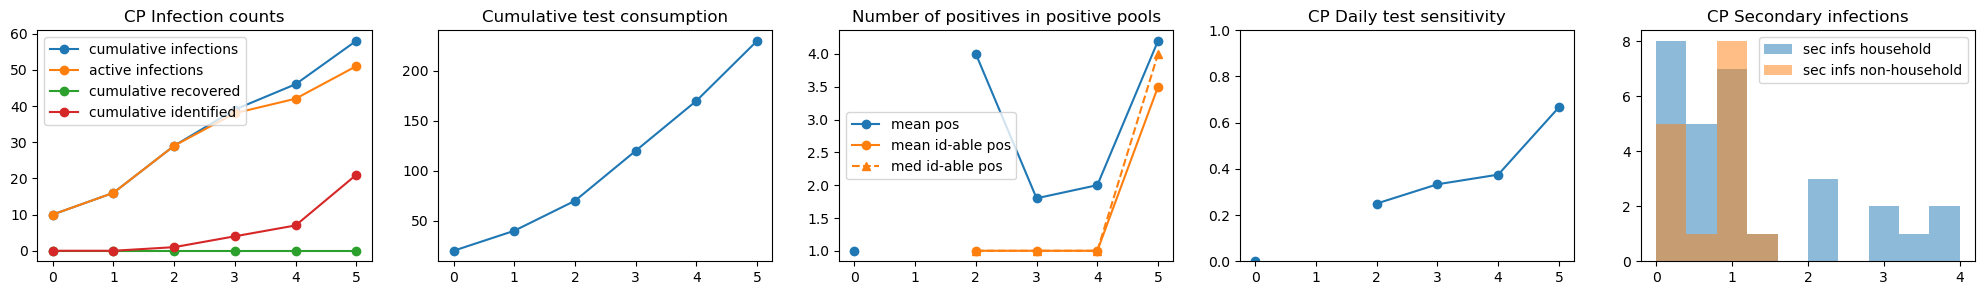

In [9]:
cp_plot = plot_results(cp_sim, "correlated")

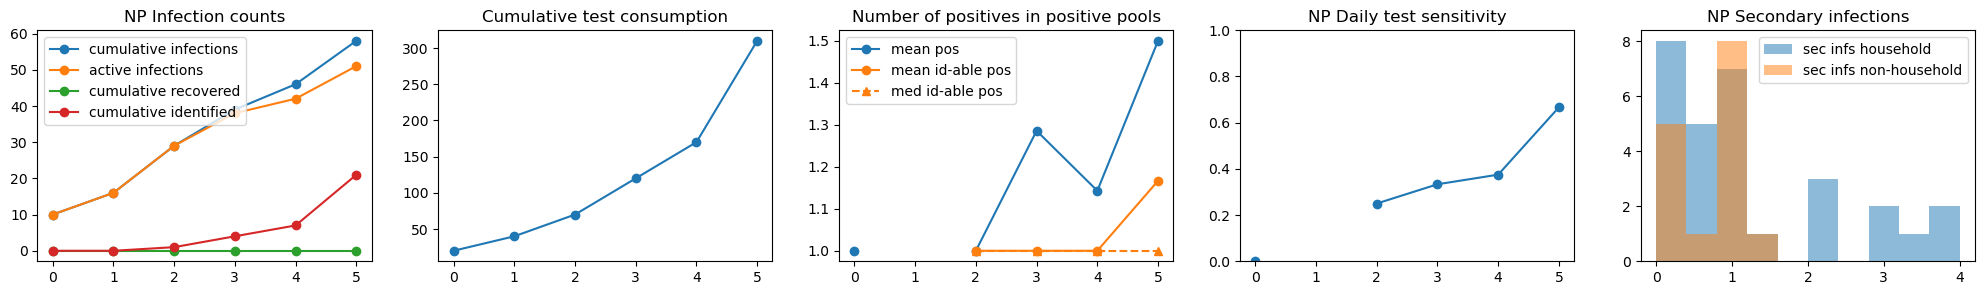

In [10]:
np_plot = plot_results(np_sim, "naive")

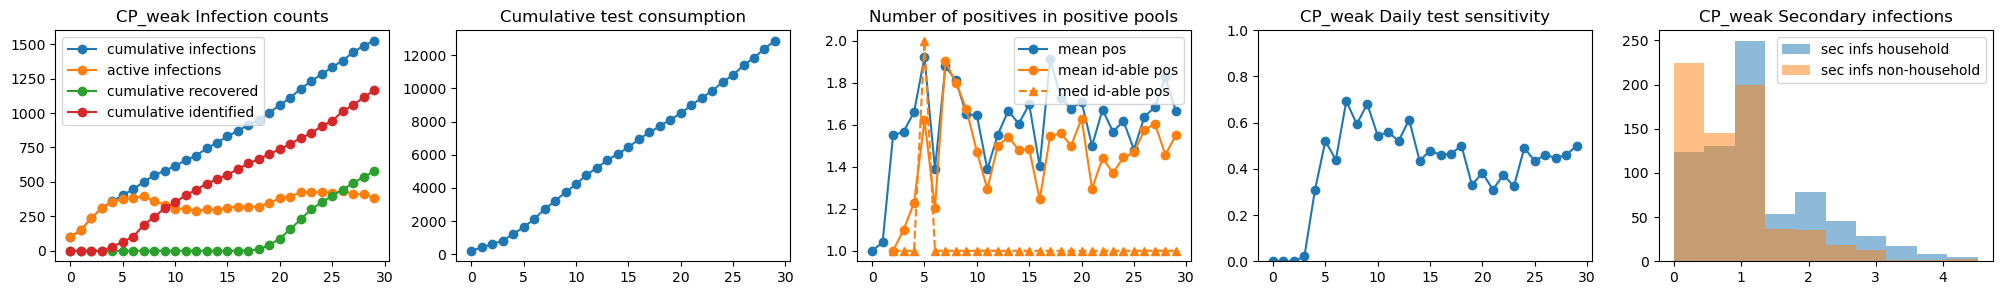

In [23]:
cp_weak_plot = plot_results(cp_weak_sim, "correlated_weak")

In [13]:
len(cp_sim.model.isolation_start_times)

5000

In [33]:
min(cp_sim.model.VL_over_time["time_points"], key=lambda x: abs(x-10))

9.992697613156514

In [37]:
cp_sim.model.VL_over_time["time_points"].index(9.992697613156514)

751

In [ ]:
cp_sim.model.VL_over_time["time_points"].index(
    min(
        cp_sim.model.VL_over_time["time_points"], 
        key=lambda x: abs(x-cp_sim.model.isolation_start_times[j])
        ))

In [34]:
values = [1,2,3,4,5]

In [36]:
values.__getitem__

<function list.__getitem__>

In [35]:
index_min = min(range(len(values)), key=values.__getitem__)
index_min

0

In [30]:
cp_sim.model.VL_over_time["VL_time_series"]

5000

In [18]:
cp_VL_at_isolation = []
np_VL_at_isolation = []
cp_isolation_time_variance = []
np_isolation_time_variance = []

i = 0
while i < len(list(cp_sim.model.households_dict.values())):
    household = list(cp_sim.model.households_dict.values())[i]
    cp_household_isolation_times = [np.round(cp_sim.model.isolation_start_times[j],2) for j in household]
    cp_household_VL_at_isolation = [
        np.round(cp_sim.model.VL_over_time["VL_time_series"][j][
            cp_sim.model.VL_over_time["time_points"].index(
                min(
                    cp_sim.model.VL_over_time["time_points"], 
                    key=lambda x: abs(x-cp_sim.model.isolation_start_times[j])
                )
            )], 2)
        for j in household
    ]
    cp_VL_at_isolation.extend(cp_household_VL_at_isolation)
    np_household_isolation_times = [np.round(np_sim.model.isolation_start_times[j],2) for j in household]
    np_household_VL_at_isolation = [
        np.round(np_sim.model.VL_over_time["VL_time_series"][j][
            np_sim.model.VL_over_time["time_points"].index(
                min(
                    np_sim.model.VL_over_time["time_points"], 
                    key=lambda x: abs(x-np_sim.model.isolation_start_times[j])
                )
            )], 2)
        for j in household
    ]
    np_VL_at_isolation.extend(np_household_VL_at_isolation)
    if any((cp_household_isolation_times[j]<100000) or (np_household_isolation_times[j]<100000) for j in range(len(household))):
        cp_isolation_time_variance.append(np.var(list(filter(lambda x: x<100000, cp_household_isolation_times))))
        np_isolation_time_variance.append(np.var(list(filter(lambda x: x<100000, np_household_isolation_times))))
        print(
            "household: ", household, 
            "\n    CP isolation time: ", cp_household_isolation_times, ", VL at isolation: ", cp_household_VL_at_isolation,
            "\n    NP isolation time: ", np_household_isolation_times, ", VL at isolation: ", np_household_VL_at_isolation,
        )
    i += len(household)

household:  [583, 3852, 3851, 3850, 3849] 
    CP isolation time:  [6.0, 6.0, 11.01, 11.01, 6.0] , VL at isolation:  [5.55, 5.68, 5.53, 5.37, 6.0] 
    NP isolation time:  [6.0, 6.0, 11.0, 100000.0, 6.0] , VL at isolation:  [5.54, 5.69, 5.54, -1.0, 6.0]
household:  [4994] 
    CP isolation time:  [100000.0] , VL at isolation:  [-1.0] 
    NP isolation time:  [42.01] , VL at isolation:  [5.15]
household:  [4993] 
    CP isolation time:  [17.0] , VL at isolation:  [5.42] 
    NP isolation time:  [100000.0] , VL at isolation:  [-1.0]
household:  [3832, 3831, 3830] 
    CP isolation time:  [24.01, 24.01, 24.01] , VL at isolation:  [5.52, 5.96, 5.72] 
    NP isolation time:  [100000.0, 100000.0, 100000.0] , VL at isolation:  [-1.0, -1.0, -1.0]
household:  [579, 3829] 
    CP isolation time:  [45.0, 45.0] , VL at isolation:  [6.0, 5.92] 
    NP isolation time:  [100000.0, 20.0] , VL at isolation:  [-1.0, 5.97]
household:  [3826, 3825, 3824, 3823] 
    CP isolation time:  [100000.0, 100000.0,

(array([995.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ,
        202.5, 225. ]),
 <BarContainer object of 10 artists>)

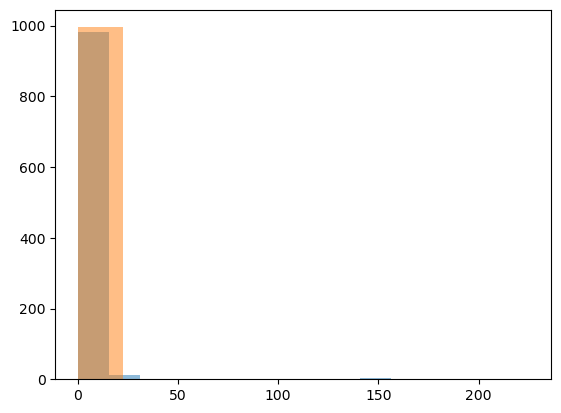

In [11]:
plt.hist(np.array(cp_isolation_time_variance)[~np.isnan(cp_isolation_time_variance)], alpha=0.5, label="CP")
plt.hist(np.array(np_isolation_time_variance)[~np.isnan(np_isolation_time_variance)], alpha=0.5, label="NP")

Text(0, 0.5, 'Density')

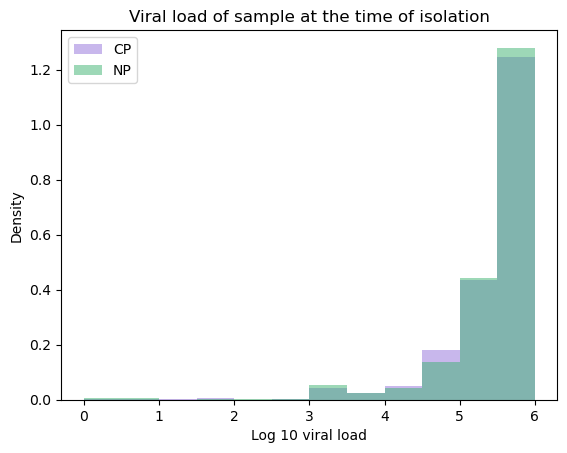

In [19]:
bins = np.linspace(0,6,13)
plt.hist(list(filter(lambda x: x>-1, cp_VL_at_isolation)), alpha=0.5, label="CP", density=True, bins=bins, color="mediumpurple")
plt.hist(list(filter(lambda x: x>-1, np_VL_at_isolation)), alpha=0.5, label="NP", density=True, bins=bins, color="mediumseagreen")
plt.legend()
plt.title("Viral load of sample at the time of isolation")
plt.xlabel("Log 10 viral load")
plt.ylabel("Density")

Generated overall age distribution:
0-9: 0.1176	(-0.0034 from target)
10-19: 0.1384	(0.0074 from target)
20-29: 0.1408	(0.0038 from target)
30-39: 0.1332	(0.0002 from target)
40-49: 0.1158	(-0.0082 from target)
50-59: 0.1288	(-0.0022 from target)
60-69: 0.1194	(0.0044 from target)
70-79: 0.0746	(0.0046 from target)
80+: 0.0314	(-0.0066 from target)

Generated household size distribution:
1: 0.2756	(-0.0081 from target)
2: 0.3536	(0.0084 from target)
3: 0.1400	(-0.0106 from target)
4: 0.1400	(0.0124 from target)
5: 0.0533	(-0.0045 from target)
6: 0.0261	(0.0035 from target)
7: 0.0113	(-0.0011 from target)
Num households: 2028
mean household size: 2.448393594

{'0-9': 588, '10-19': 692, '20-29': 704, '30-39': 666, '40-49': 579, '50-59': 644, '60-69': 597, '70-79': 373, '80+': 157}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Running simulation with seed 1 for strategy correlated_weak...
Running screening for group 0 on day 0...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


Viral loads in positive pools:  [[], [], [], [], [], [], [], []]
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Viral loads in positive pools:  [[], [], [], [], [], [], [], []]
Screening day:  1  self.model.t:  1.0000000000000007
Running screening for group 2 on day 2...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


Viral loads in positive pools:  [[], [], [], [], [], [], [], [], []]
Screening day:  2  self.model.t:  2.0000000000000013
    Nodes with transition propensities:
        node4717, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 4717 is transitioning EtoIPRE at time 2.210004320849983 with timer_state: [2.21000432]; 1/sigma: [2.20323809]; VL: 0.0
{'t': 2.210004320849983, 'transitionNode': 4717, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node2928, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 2928 is transitioning EtoIPRE at time 2.2200101095720535 with timer_state: [2.22001011]; 1/sigma: [2.21315872]; VL: 5.991448250710673
{'t': 2.2200101095720535, 'transitionNode': 2928, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.05598888992
    Nodes with transition propensities:
        node4576, in state

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Viral loads in positive pools:  [[4.291745494445998], [3.8586989817046855], [6.0], [4.183914110016636], [4.286515202745176], [5.116022910622989], [3.925970117253612], [3.7104166226640016], [5.353677595157334, 3.7414572427639823], [5.206000110549301], [4.686007154146534], [5.756203040675063]]
Screening day:  3  self.model.t:  3.0085998308729143
    Nodes with transition propensities:
        node4743, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 4743 is transitioning EtoIPRE at time 3.0286001872175836 with timer_state: [3.02860019]; 1/sigma: [3.02257179]; VL: 5.952414106501058
{'t': 3.0286001872175836, 'transitionNode': 4743, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100011.75365465393
    Nodes with transition propensities:
        node1644, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 1644 is transitioning EtoIPRE at time 3.068603814132835 with timer_state: [3.06860381]; 1/sigma: [3.06424846]; VL: 5.930

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Viral loads in positive pools:  [[5.123234686840719], [5.362484566087693], [0.1112123853729745, 6.0], [6.0], [2.1233156546423384, 0.9938520131420965], [6.0], [6.0, 2.0283035097228796], [1.6730774078193247, 1.3049616900901544], [0.4878261212062797, 0.5165721590620724, 6.0], [0.7693566100000154, 6.0], [0.19559357202642136], [6.0, 0.35075161121165727], [4.581328027120122, 4.708677505881059], [4.899193329780308]]
Screening day:  4  self.model.t:  4.001078072585032
    Nodes with transition propensities:
        node4959, in state [1], propensity [('StoE', 2.380952380952381)]
infected: 4959, transmissionTerms_I: [10.], transmissionTerms_Q: [0], household_neighbors: {3776, 3777}, non_household_neighbors: [3951]
Household member states: [array([2]), array([3])]
Non-household member states: [array([1])]
Infected node 4959 got contribution from infectious contacts {3777: 1.0} and quarantined contacts {}
{'t': 4.0129337874787305, 'transitionNode': 4959, 'transitionNodeVL': 0.0, 'transitionType':

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Viral loads in positive pools:  [[5.409403954410664], [3.2878604732080476], [2.212379798389749], [1.015669399867731], [6.0], [1.758890560821036], [2.6130625128928506], [6.0], [2.6982216711433646], [2.836093231815667, 0.5736366755083266], [6.0], [6.0], [0.6309094215571253], [1.3473170638351022], [2.145466569403655, 6.0, 0.29456015210449227], [2.5008403616586556], [2.950990803387375, 6.0], [5.961647373864712]]
Screening day:  5  self.model.t:  5.006777072948046
    Nodes with transition propensities:
        node1574, in state [1], propensity [('StoE', 1.0869565217391304)]
infected: 1574, transmissionTerms_I: [10.], transmissionTerms_Q: [0], household_neighbors: {76, 1573}, non_household_neighbors: [1856, 1793, 2629, 2054, 2183, 2887, 1545, 1353, 1362, 1555, 1620, 1623, 1368, 1820, 1638, 1511, 1323, 2489, 1389, 1790, 1519, 2545, 1970, 1587, 1977, 2366]
Household member states: [array([1]), array([3])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Viral loads in positive pools:  [[5.358229172005893, 3.564082779449324], [2.1103681542353527], [2.1928240935249703, 5.6525067449381385, 2.917244555026072], [4.7024200577060915], [5.619363311601962], [4.964394222401985, 5.738026993365026, 3.0679762549754406, 3.488380256640476, 5.777419631770253], [3.010445298591141, 2.929548360535337], [2.010541756198479, 1.4260533875037569], [1.7450513786287944, 1.414259138128071, 6.0], [0.2658162315898468], [5.512308644813117], [4.405383202683728, 3.338255027263016], [5.98528720099336], [4.413139132442233]]
Screening day:  6  self.model.t:  6.00230991887696
    Nodes with transition propensities:
        node1997, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 1997 is transitioning QPREtoQSYM at time 6.012312879176544 with timer_state: [2.45439339]; 1/lamda: [2.44993153]; VL: 6.0
{'t': 6.012312879176544, 'transitionNode': 1997, 'transitionNodeVL': 5.997185085963309, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propens

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Viral loads in positive pools:  [[5.723518132021851], [3.680208421007354], [0.7946518811095126], [2.1931329915108058], [5.227695414236112], [3.2038597761969942], [0.06799940244741466], [4.185982609356915, 5.622083599532629, 5.404929955018599], [6.0], [0.5454860034092391], [4.1680454273613226], [0.6678442962786573], [3.2673015429575902], [5.809693336228084], [4.097608398559949, 2.6134782900282496, 5.435605884152861], [5.805411130511636], [5.047186704144848], [3.186811770900903], [3.989867986777091], [5.12249730565448, 5.082597832257411], [6.0]]
Screening day:  7  self.model.t:  7.002926153890872
    Nodes with transition propensities:
        node1371, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 1371 is transitioning EtoIPRE at time 7.032930203969083 with timer_state: [2.89460593]; 1/sigma: [2.89427718]; VL: 5.917750868802061
{'t': 7.032930203969083, 'transitionNode': 1371, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Viral loads in positive pools:  [[5.733186808735368], [5.773897254241344], [3.474491978237155], [0.024900982996563223], [6.0], [5.659062638723637, 3.9376585221489124], [4.749983237505781], [4.211826122576004], [3.86313556970985], [2.8662566975267874], [3.49695654089843, 5.365019783646735, 5.8209922241494, 6.0], [5.349065957741839, 5.827102732603556, 5.650048034223382, 5.425120748667419], [5.581025980178928, 4.48277639726528], [6.0], [4.702120372958957, 4.930751205929338], [5.065866037178035], [5.995579411027833], [5.92580543203047], [5.120780904732091, 3.234875721573356, 5.563264181496198], [1.0108159569545434, 6.0, 3.2633943292168865], [1.1710799008534247], [5.334256981371335, 4.0278490437211705], [6.0, 3.7760447648528843], [5.2338241750943695], [6.0]]
Screening day:  8  self.model.t:  8.005834727503538
    Nodes with transition propensities:
        node1835, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 1835 is transitioning IPREtoISYM at time 8.015839499672675 with ti

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Viral loads in positive pools:  [[4.576555778351852, 4.702645136242375], [5.806024415093815], [4.982826308034659, 6.0], [5.235277405110887, 6.0], [5.645429414216357], [4.998424555856742, 6.0, 6.0], [5.70762764670554, 4.411977060593266], [4.637444062142043], [5.849183928501913, 6.0], [5.355273360420215], [6.0, 5.668250525048052], [6.0, 5.278650529909349], [6.0], [3.331856593035056], [6.0, 6.0], [6.0, 0.18654800725432003, 1.4695947377261611], [5.152013160154472], [4.876684816989414, 5.921347813306993]]
Screening day:  9  self.model.t:  9.00509354190576
    Nodes with transition propensities:
        node1364, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 1364 is transitioning IPREtoISYM at time 9.01509779916308 with timer_state: [2.30224014]; 1/lamda: [2.29571232]; VL: 6.0
{'t': 9.01509779916308, 'transitionNode': 1364, 'transitionNodeVL': 5.9967237851585296, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100015.94781372666
    Nodes with tra

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Viral loads in positive pools:  [[6.0, 6.0], [1.200152245963912], [0.8209550780594366, 0.7645308873133682], [1.4126123777650221, 6.0], [3.757143873283107], [2.320800327643694], [6.0, 5.053803143965876, 3.6993232499674344], [5.735587219365033, 6.0, 3.9990478679304458, 5.182939818984191, 5.7591323512177], [5.585942643503452, 4.584274680374401], [1.8633339712694146, 2.6925992372976117, 0.37175996021164626], [5.427133731870439], [5.929708088421306, 5.455099376933745, 6.0], [5.904336883657817], [0.2936658099918108, 4.789088348000918, 0.02405186059982654], [5.67554696097305], [0.5257872989409722], [6.0, 2.0983503206990686]]
Screening day:  10  self.model.t:  10.00247593762701
    Nodes with transition propensities:
        node115, in state [1], propensity [('StoE', 1.282051282051282)]
infected: 115, transmissionTerms_I: [10.], transmissionTerms_Q: [0], household_neighbors: {114, 4069, 1743}, non_household_neighbors: [35, 102, 77, 53, 120, 26, 27, 317, 127]
Household member states: [array([1

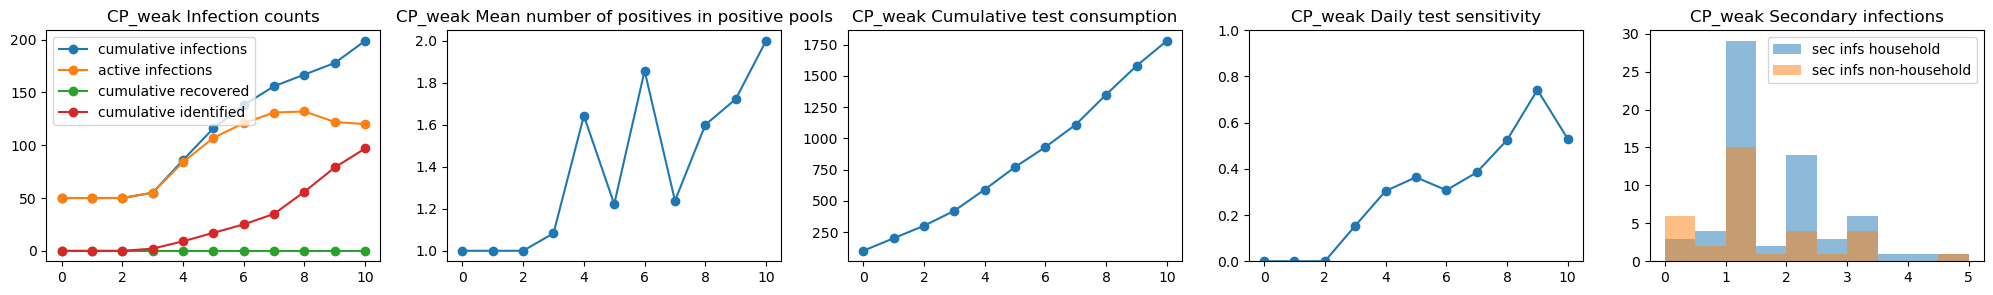

In [18]:
cpw_sim, cpw_fig = run_and_plot(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='correlated_weak',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    COMMUNITY_SIZE=COMMUNITY_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    seed=SEED,
)

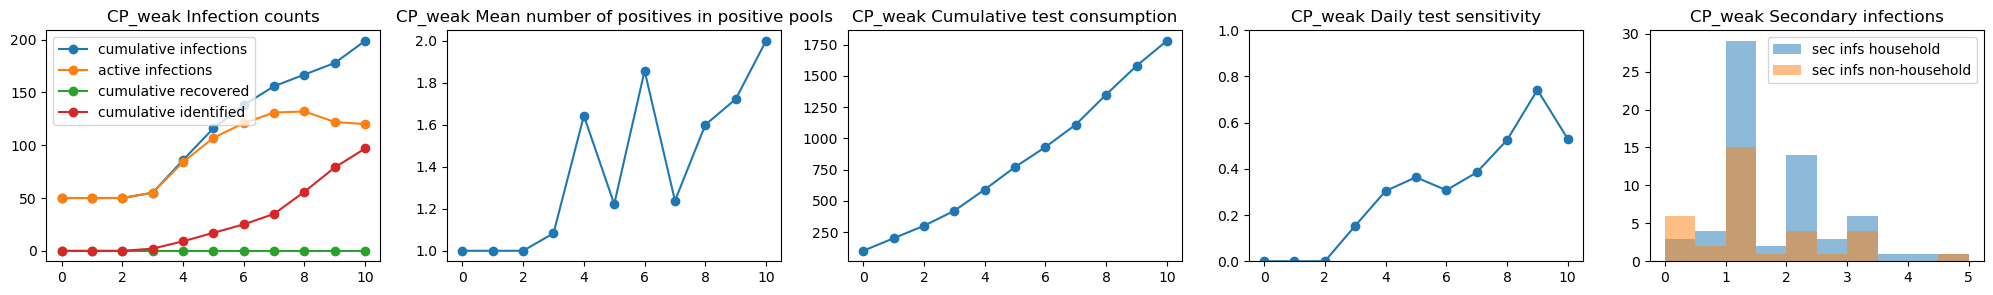

In [19]:
cpw_fig

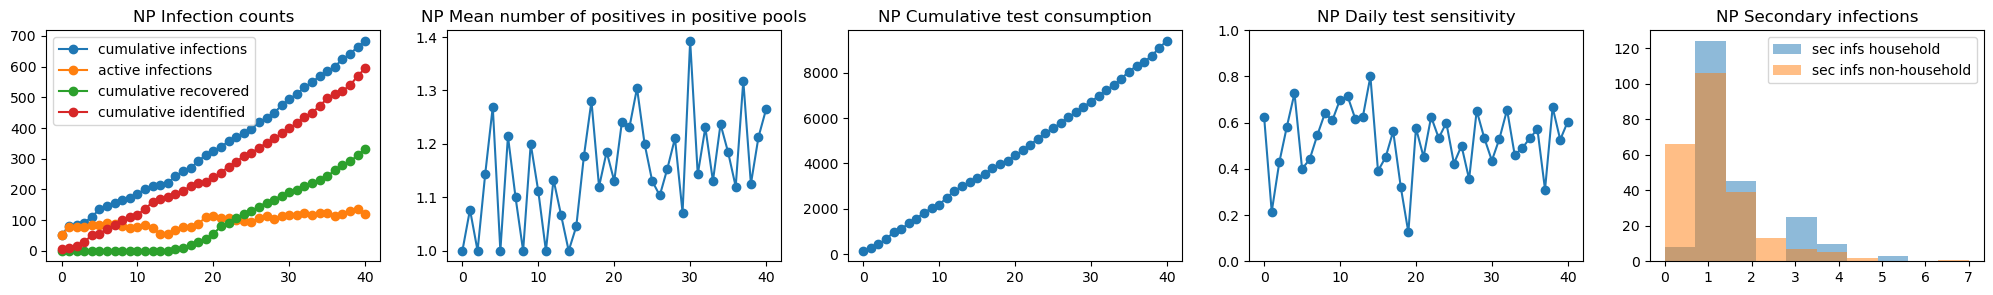

In [9]:
np_fig

Generated overall age distribution:
0-9: 0.1145	(-0.0065 from target)
10-19: 0.1285	(-0.0025 from target)
20-29: 0.1380	(0.0010 from target)
30-39: 0.1465	(0.0135 from target)
40-49: 0.1090	(-0.0150 from target)
50-59: 0.1340	(0.0030 from target)
60-69: 0.1110	(-0.0040 from target)
70-79: 0.0720	(0.0020 from target)
80+: 0.0465	(0.0085 from target)

Generated household size distribution:
1: 0.3035	(0.0198 from target)
2: 0.3378	(-0.0073 from target)
3: 0.1236	(-0.0271 from target)
4: 0.1310	(0.0033 from target)
5: 0.0624	(0.0046 from target)
6: 0.0294	(0.0068 from target)
7: 0.0122	(-0.0002 from target)
Num households: 817
mean household size: 2.448393594

{'0-9': 229, '10-19': 257, '20-29': 276, '30-39': 293, '40-49': 218, '50-59': 268, '60-69': 222, '70-79': 144, '80+': 93}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Running simulation with seed 0 for strategy naive...
Running screening for group 0 on day 0...
Viral loads in positive pools:  [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]]
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...
Viral loads in positive pools:  [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0], [-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]]
Screening day:  1  self.model.t:  1.0000000000000007
Running screening for group 2 on day 2...
Viral loads in positive pools:  [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0], [-1.0, -1.0, -1.0, -

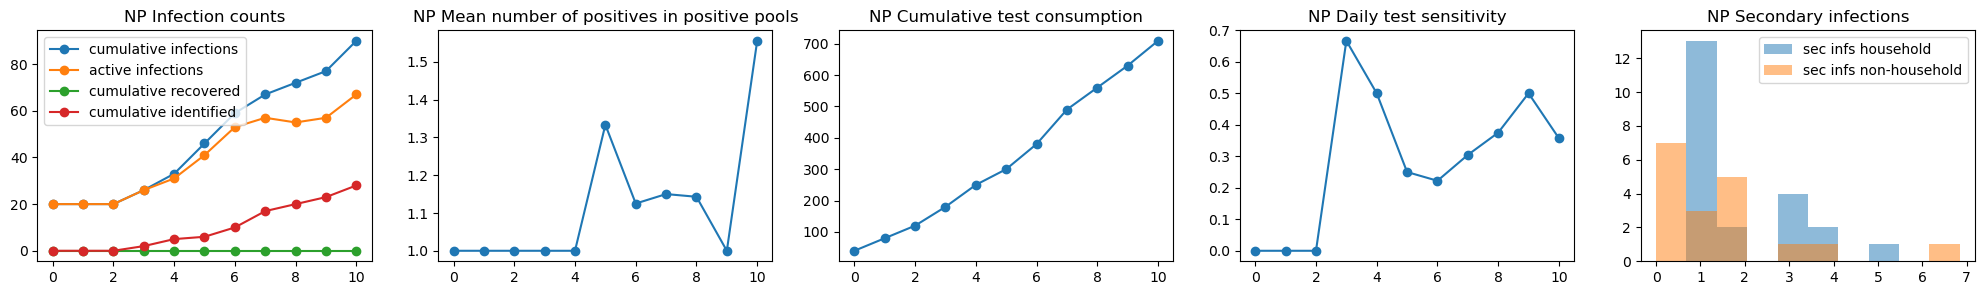

In [20]:
importlib.reload(seirsplus)

np_sim, np_fig = run_and_plot(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=10,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    seed=SEED,
)

(array([ 4.,  2.,  2.,  2., 54., 12., 13.,  9., 10., 16.]),
 array([0.33259514, 0.89933563, 1.46607611, 2.0328166 , 2.59955708,
        3.16629757, 3.73303806, 4.29977854, 4.86651903, 5.43325951,
        6.        ]),
 <BarContainer object of 10 artists>)

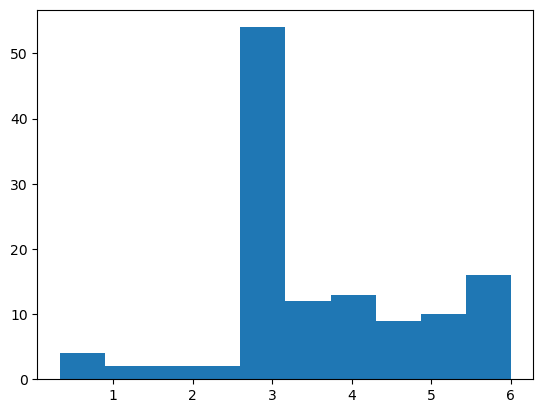

In [15]:
plt.hist([v for v in cp_sim.model.current_VL if v > 0])

In [16]:
min([0,1,2,3])

0

In [25]:
max(max(np_sim.model.sec_infs_household.values()), max(np_sim.model.sec_infs_non_household.values()))

11.976809068203297

In [30]:
sum(sim_correlated.model.degree - sim_correlated.model.degree_Q)

array([0.])

In [59]:
node=545
sim_correlated.model.transmissionTerms_Q[node], sim_correlated.model.transmissionTerms_I[node]

(array([0.]), array([40.]))

In [92]:
# np.where(not np.equal(sim_correlated.model.transmissionTerms_Q, sim_correlated.model.transmissionTerms_I))

res = [(i, (x[0],y[0])) for i, (x, y) in enumerate(zip(sim_correlated.model.transmissionTerms_Q, sim_correlated.model.transmissionTerms_I)) if x != y]
res


[(126, (0.0, 0.1)),
 (128, (0.0, 0.1)),
 (129, (0.0, 0.1)),
 (130, (0.0, 0.1)),
 (131, (0.0, 0.1)),
 (132, (0.1, 0.0)),
 (133, (0.0, 0.1)),
 (135, (0.0, 0.1)),
 (138, (0.1, 0.0)),
 (139, (0.0, 0.1)),
 (145, (0.0, 0.1)),
 (150, (0.0, 0.1)),
 (151, (0.0, 0.1)),
 (152, (0.0, 10.0)),
 (153, (0.0, 0.1)),
 (155, (0.2, 0.0)),
 (161, (0.0, 0.1)),
 (166, (0.0, 0.1)),
 (167, (0.0, 0.1)),
 (168, (0.0, 0.1)),
 (170, (0.0, 0.1)),
 (173, (0.0, 0.1)),
 (176, (0.0, 0.1)),
 (178, (0.0, 0.1)),
 (179, (0.0, 0.1)),
 (182, (0.0, 0.1)),
 (184, (0.0, 0.1)),
 (185, (0.0, 0.1)),
 (188, (0.0, 0.1)),
 (195, (10.0, 0.1)),
 (205, (0.0, 0.1)),
 (207, (0.0, 0.1)),
 (209, (0.0, 0.1)),
 (211, (0.0, 0.1)),
 (214, (0.2, 0.1)),
 (215, (0.0, 0.1)),
 (217, (0.0, 0.1)),
 (220, (0.0, 0.1)),
 (221, (0.0, 0.1)),
 (226, (0.0, 0.1)),
 (227, (0.0, 0.1)),
 (232, (0.0, 0.1)),
 (233, (0.0, 0.1)),
 (241, (0.0, 0.1)),
 (250, (0.0, 0.1)),
 (261, (0.0, 0.1)),
 (263, (0.0, 0.1)),
 (264, (0.0, 0.1)),
 (267, (0.0, 0.1)),
 (270, (0.0, 0.1))

In [60]:
sim_correlated.model.infectionsLog

[{'t': 1.288447906784009,
  'infected_node': 927,
  'infection_type': 'StoE',
  'infected_node_degree': array([54.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 1, 1, 1, 1])},
 {'t': 1.3289722093335052,
  'infected_node': 545,
  'infection_type': 'StoE',
  'infected_node_degree': array([56.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 1, 1, 1, 2])},
 {'t': 1.6479340654636487,
  'infected_node': 546,
  'infection_type': 'StoE',
  'infected_node_degree': array([57.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 1, 1, 2, 2])},
 {'t': 1.8334123874999255,
  'infected_node': 925,
  'infection_type': 'StoE',
  'infected_node_degree': array([52.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 2, 1, 2, 2])},
 {'t': 3.408402162224979,
  'infected_node': 547,
  'infection_type': 'St

In [54]:
sum(sim_correlated.model.beta_local - sim_correlated.model.beta_Q_local)

array([0.])

In [32]:
sim_correlated.model.sec_infs_non_household

defaultdict(int,
            {840: 2.0,
             926: 1.0,
             776: 1.2,
             830: 1.2,
             831: 0.20990099009900992,
             789: 0.2,
             828: 0.2})

In [33]:
sim_correlated.model.sec_infs_household

defaultdict(int,
            {926: 5.0,
             840: 1.0,
             887: 2.0,
             830: 3.0,
             789: 2.99009900990099,
             863: 1.0})

In [110]:
len(sim_correlated.model.infectionsLog)

6

In [120]:
sum(sim_correlated.model.sec_infs_non_household.values()) + sum(sim_correlated.model.sec_infs_household.values())

143.00000000000003

In [27]:
sim_correlated.model.households_dict[927]

{545, 546, 547, 925, 926}

In [28]:
set(list(sim_correlated.model.G._adj[927].keys())) - set(sim_correlated.model.households_dict[927])

{778, 801, 808, 809}

Text(0.5, 1.0, '# susceptible neighbors')

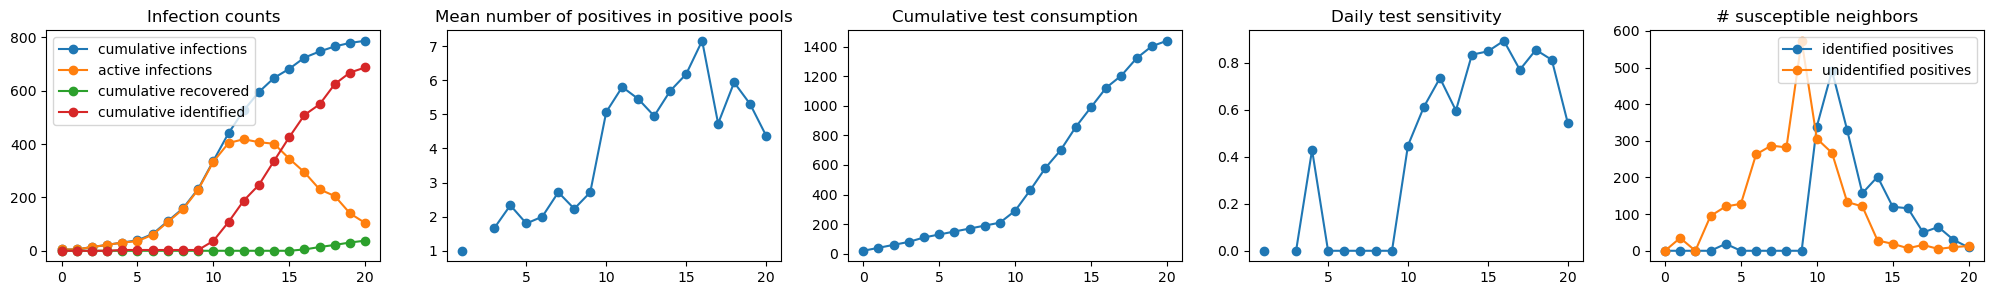

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

sim = sim_correlated

axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors")

In [ ]:
# get infection start times of members of infected households 

for household in households:
    if not all(sim_correlated.model.infection_start_times[node_id] == 1e5 for node_id in household["indices"]):
        print("Household: ", household['indices'])
        print([(node_id, sim_correlated.model.infection_start_times[node_id]) for node_id in household["indices"]])



In [ ]:
# can confirm that they are infected aroud the same time

## Naive pooling

In [24]:

random.seed(SEED)
np.random.seed(SEED)

from seirsplus.networks import generate_demographic_contact_network, household_country_data

demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=N, demographic_data=household_country_data('US'), 
                                                            distancing_scales=[0.7], isolation_groups=[])

G = demographic_graphs['baseline']

G_weighted = copy.deepcopy(G)

for e in G.edges():
    if "weight" not in G[e[0]][e[1]]:
        G[e[0]][e[1]]["weight"] = WEIGHT

for e in G_weighted.edges():
    if "weight" not in G_weighted[e[0]][e[1]]:
        G_weighted[e[0]][e[1]]["weight"] = 10**10


households_dict = {}
for household in households:
    for node_id in household["indices"]:
        households_dict[node_id] = household["indices"]
               
sim_naive = run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T=20,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    seed=SEED,
)


Generated overall age distribution:
0-9: 0.1360	(0.0150 from target)
10-19: 0.1340	(0.0030 from target)
20-29: 0.1420	(0.0050 from target)
30-39: 0.1370	(0.0040 from target)
40-49: 0.1190	(-0.0050 from target)
50-59: 0.1390	(0.0080 from target)
60-69: 0.1000	(-0.0150 from target)
70-79: 0.0500	(-0.0200 from target)
80+: 0.0430	(0.0050 from target)

Generated household size distribution:
1: 0.3230	(0.0393 from target)
2: 0.3587	(0.0136 from target)
3: 0.1140	(-0.0367 from target)
4: 0.1045	(-0.0231 from target)
5: 0.0451	(-0.0126 from target)
6: 0.0333	(0.0106 from target)
7: 0.0214	(0.0089 from target)
Num households: 421
mean household size: 2.448393594

{'0-9': 136, '10-19': 134, '20-29': 142, '30-39': 137, '40-49': 119, '50-59': 139, '60-69': 100, '70-79': 50, '80+': 43}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Running simulation with seed 2 for strategy naive...
Running screening for group 0 on day 0...
Viral loads in positive pools:  []
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...
Viral loads in positive pools:  []
Screening day:  1  self.model.t:  1.0000000000000007
    Nodes with transition propensities:
        node61, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 61 is transitioning EtoIPRE at time 1.0000014764313119 with timer_state: [1.00000148]; 1/sigma: [1.]; VL: 0.0
{'t': 1.0000014764313119, 'transitionNode': 61, 'transitionNodeVL': 4.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 500000.0
    Nodes with transition propensities:
        node311, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 311 is transitioning EtoIPRE at time 1.0000015211666329 with timer_state: [1.00000152]; 1/sigma: [1.]; VL: 4.0
{'t': 1.0000015211666329, 'transitionNode': 311, 'transitionNodeVL': 4.0, 'transitionType': 'Et

Text(0.5, 1.0, '# susceptible neighbors')

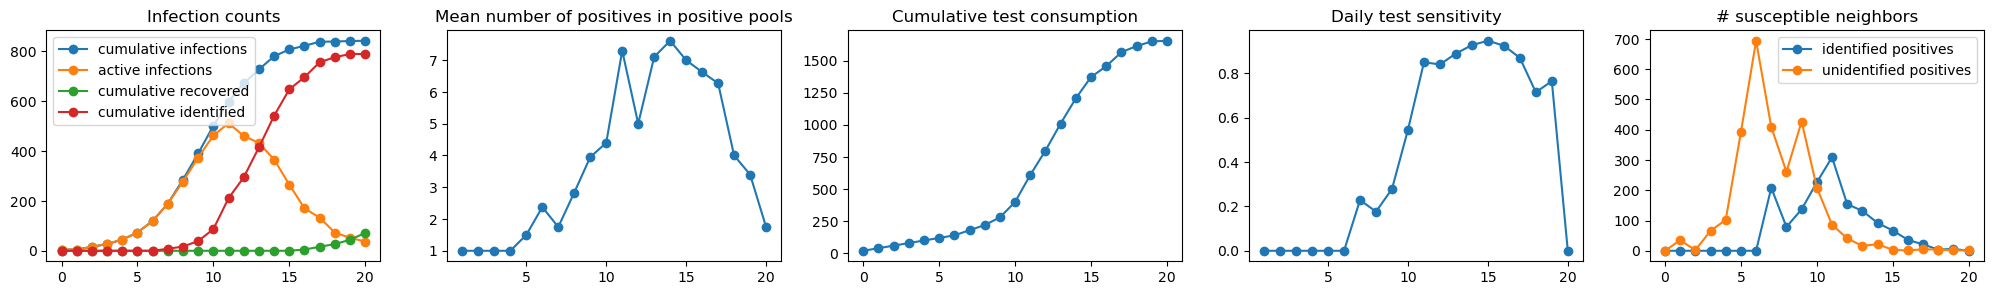

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

sim = sim_naive

axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors")

# below old

In [21]:
random.seed(0)
np.random.seed(0)

N = 2000
INIT_EXPOSED = int(N*0.002)

from seirsplus.networks import generate_demographic_contact_network, household_country_data

demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=N, demographic_data=household_country_data('test10'),
                                                            layer_generator = "LFR", 
                                                            distancing_scales=[0.7], isolation_groups=[])

G = demographic_graphs['baseline']
# assign higher weights to inter-household edges
for e in G.edges():
    if "weight" not in G[e[0]][e[1]]:
        G[e[0]][e[1]]["weight"] = WEIGHT

households_dict = {}
for household in households:
    for node_id in household["indices"]:
        households_dict[node_id] = household["indices"]


"""
0-9: 0.1145	(-0.0065 from target)
10-19: 0.1285	(-0.0025 from target)
20-29: 0.1380	(0.0010 from target)
30-39: 0.1465	(0.0135 from target)
40-49: 0.1090	(-0.0150 from target)
50-59: 0.1340	(0.0030 from target)
60-69: 0.1110	(-0.0040 from target)
70-79: 0.0720	(0.0020 from target)
80+: 0.0465	(0.0085 from target)

Generated household size distribution:
1: 0.3035	(0.0198 from target)
2: 0.3378	(-0.0073 from target)
3: 0.1236	(-0.0271 from target)
4: 0.1310	(0.0033 from target)
5: 0.0624	(0.0046 from target)
6: 0.0294	(0.0068 from target)
7: 0.0122	(-0.0002 from target)
Num households: 817
mean household size: 2.448393594
"""

householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u2

KeyboardInterrupt: 

In [6]:
from seirsplus.viral_model import ViralExtSEIRNetworkModel
from seirsplus.sim_loops_pooled_test import SimulationRunner

test_model = ViralExtSEIRNetworkModel(
    G = G,
    households_dict=households_dict,
    beta = 0.1,
    # beta_Q = 0,
    sigma = 0.2,
    lamda = 0.5,
    gamma  = 0.25,
    seed = 0,
    alpha = ALPHA,
    initE = INIT_EXPOSED,
    transition_mode = "time_in_state",
    verbose=1,
    )

sim_naive = SimulationRunner(
    model = test_model,
    pooling_strategy='naive',
    T = 10,
    # num_groups = 10,
    num_groups = NUM_SCREENING_GROUPS,
    pool_size = POOL_SIZE,
    # LoD=500,
    LoD=LoD,
    seed = 0,
    # output_path = "home/yz685/corr_pooling_seirsplus/results/test",
    save_results = False,
    max_dt=0.01
)

sim_naive.run_simulation()

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yz685/corr_pooling_seirsplus/seirsplus/models.py:2344: RuntimeWarning: divide by zero encountered in divide
  propensities_ISYMtoH     = 1e5 * ((self.X==self.I_sym) & numpy.greater(self.timer_state, 1/self.eta) & numpy.less(self.rand_h, self.h))
/home/yz685/corr_pooling_seirsplus/seirsplus/models.py:2350: RuntimeWarning: divide by zero encountered in divide
  propensities_HtoF        = 1e5 * ((self.X==self.H) & numpy.greater(self.timer_state, 1/self.mu_H) & numpy.less(self.rand_f, self.f))
/home/yz685/corr_pooling_seirsplus/seirsplus/models.py:2370: RuntimeWarning: divide by zero encountered in divide
  propensities_QSYMtoH     = 1e5 * ((self.X==sel

    Nodes with transition propensities:
        node275, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 275 is transitioning EtoIPRE at time 1.0000006414993063 with timer_state: [1.00000064]; 1/sigma: [1.]; VL: 0.0
{'t': 1.0000006414993063, 'transitionNode': 275, 'transitionNodeVL': 4.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node454, in state [1], propensity [('StoE', 2.2727272727272725)]
infected: 454, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {274, 275, 276, 453}, non_household_neighbors: [424, 408, 403, 400]
Household member states: [array([1]), array([3]), array([1]), array([1])]
Non-household member states: [array([1]), array([1]), array([1]), array([1])]
Infected node 454 got contribution from infectious contacts {275: 1.0} and quarantined contacts {}
{'t': 1.0545625279706978, 'transitionNode': 454, 'transitionNodeVL': 0.0, 'transitionType': '

In [113]:
len(sim_naive.model.infectionsLog)

8

In [77]:
# sum(sim_naive.model.A_Q_deltabeta_Q.toarray() - sim_correlated.model.A_Q_deltabeta_Q.toarray())
sum(sim_naive.model.A_deltabeta.toarray() - sim_correlated.model.A_deltabeta.toarray()).sum()

0.0

(array([994.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

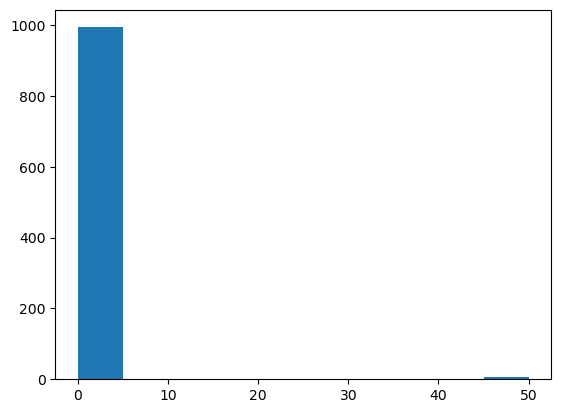

In [71]:
# if you don't set beta_Q=0, it's by default beta, 
# but then transmissionTerms_Q is different from transmissionTerms_I
plt.hist(sim_naive.model.transmissionTerms_Q - sim_naive.model.transmissionTerms_I)

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, '# susceptible neighbors of identified positives')

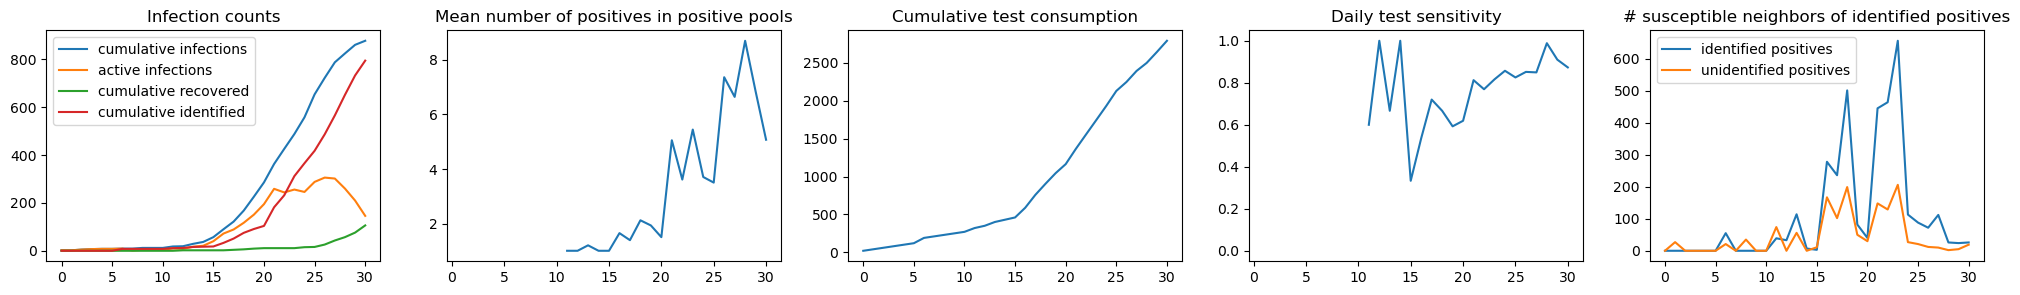

In [138]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

axs[0].plot([sim_naive.overall_results[i]["cumInfections"] for i in range(len(sim_naive.overall_results))], label="cumulative infections")
axs[0].plot([sim_naive.overall_results[i]["numActiveInfections"] for i in range(len(sim_naive.overall_results))], label="active infections")
axs[0].plot([sim_naive.overall_results[i]["cumRecovered"] for i in range(len(sim_naive.overall_results))], label="cumulative recovered")
axs[0].plot([sim_naive.overall_results[i]["cum_positives_identified"] for i in range(len(sim_naive.overall_results))], label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim_naive.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim_naive.overall_results))], label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim_naive.overall_results[i]["cum_num_tests"] for i in range(len(sim_naive.overall_results))], label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim_naive.overall_results[i]["daily_sensitivity"] for i in range(len(sim_naive.overall_results))], label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim_naive.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim_naive.overall_results))], label="identified positives")
axs[4].plot([sim_naive.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim_naive.overall_results))], label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors of identified positives")

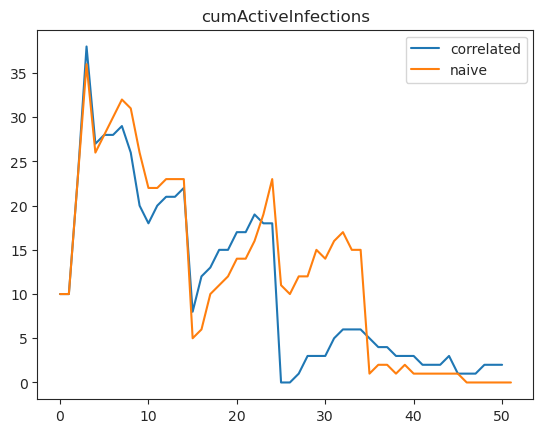

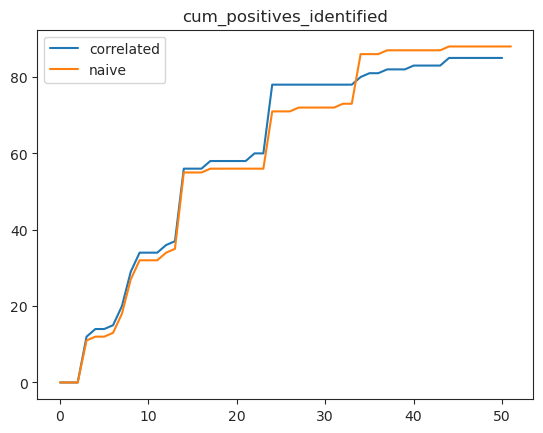

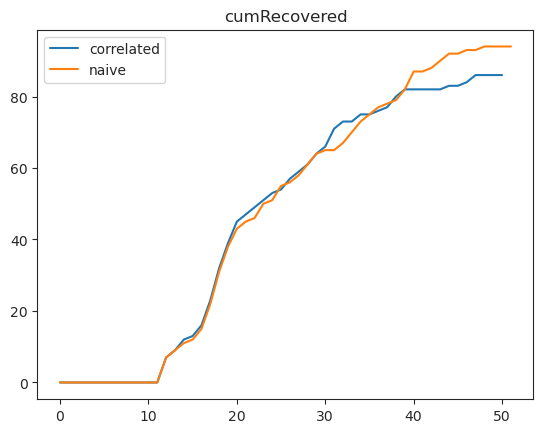

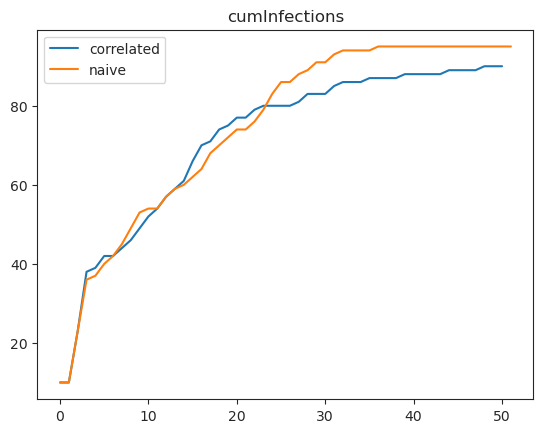

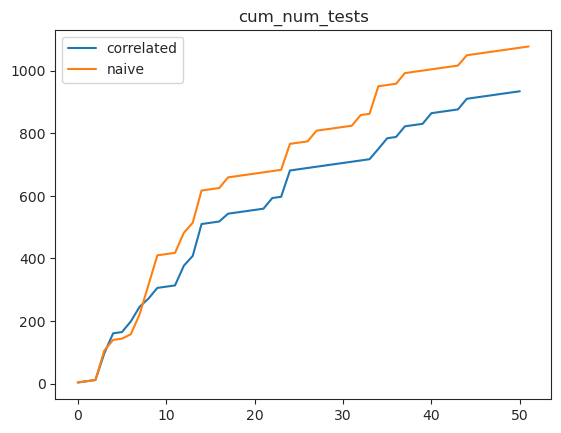

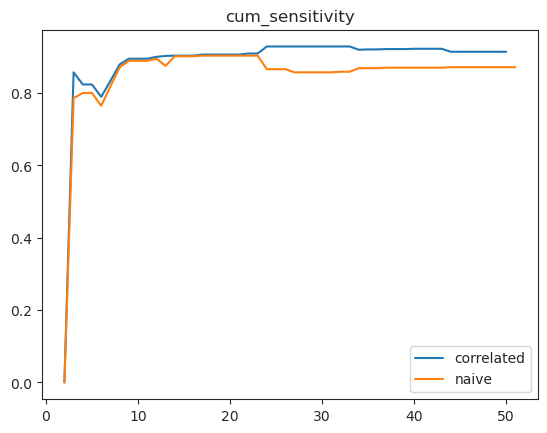

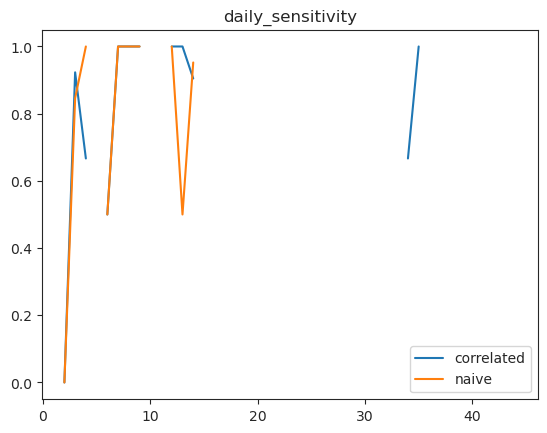

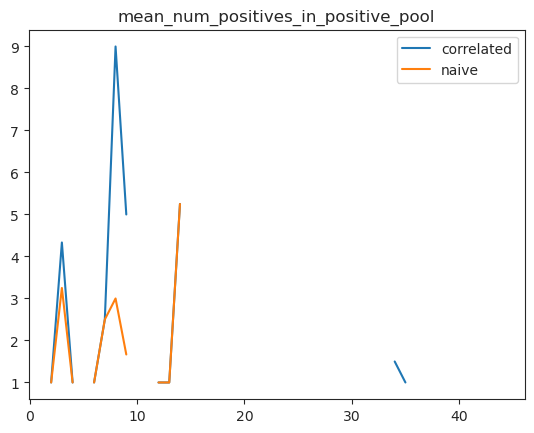

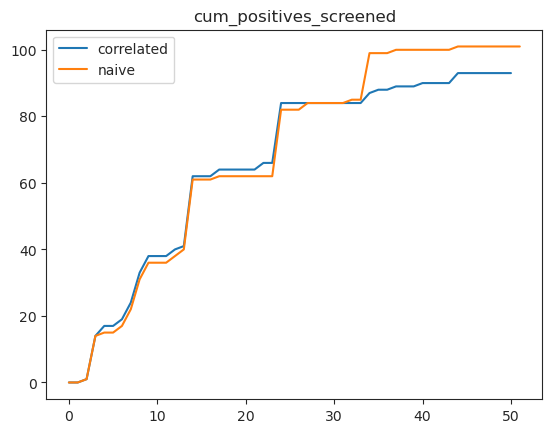

In [16]:
for metric in metrics:
    plt.plot([result[metric] for result in sim_correlated.overall_results])
    plt.plot([result[metric] for result in sim_naive.overall_results])
    plt.title(metric)
    plt.legend(['correlated', 'naive'])
    plt.show()